# PyTorch

PyTorch is an **open-source deep learning framework** developed by **Facebook’s AI Research (FAIR) lab**. It provides a flexible and expressive environment for building neural networks in Python, and it is designed around **eager execution**: computations are carried out immediately as operations are invoked, making model development intuitive, debuggable, and well suited for dynamic architectures.

At its core, PyTorch offers a powerful **tensor library** with **GPU acceleration** and an **automatic differentiation engine** that supports both research experimentation and production-grade models. Around this core, the ecosystem includes domain-specific libraries such as **torchvision**, **torchtext**, and **torchaudio** for working with images, text, and audio. These packages also provide ready-to-use implementations of **widely adopted deep learning architectures**, such as ResNet, with pretrained weights commonly used for transfer learning.

PyTorch’s emphasis on flexibility, transparency, and Pythonic design has contributed to its rapid adoption in academia and industry. Major companies, including Meta, NVIDIA, Salesforce, Uber, and Twitter, rely on PyTorch for a broad range of machine learning applications, from computer vision and natural language processing to reinforcement learning and large-scale model training.

The fundamental difference with TensorFlow and PyTorch lies in how computations are defined and executed, which strongly affects code structure, debugging, and model flexibility. Early versions of TensorFlow required users to first construct a static computation graph (an abstract representation of the model) and then execute that graph within the TensorFlow runtime. This declarative style differs from Python’s imperative programming paradigm, and as a result, TensorFlow code often felt less natural to write and harder to debug, especially for newcomers. Static graphs also make dynamic model behavior more cumbersome. Tasks such as changing the architecture on the fly, implementing conditional logic, or writing models with variable-length control flows require additional boilerplate in TensorFlow. By contrast, PyTorch evaluates operations immediately as standard Python code, making dynamic architectures and custom control flows straightforward. These differences contributed to PyTorch’s rapid adoption in research communities, where flexibility and ease of experimentation are essential. However, the landscape has changed significantly with the introduction of eager execution in TensorFlow and its full integration into TensorFlow 2.x. 

Where does Keras fit in? Keras is the high-level API originally designed to run on top of TensorFlow. It simplifies model construction and provides built-in training, validation, and testing loops—features that the lower-level library expect developers to write themselves. Compared with TensorFlow + Keras, PyTorch sits somewhere in the middle. It does not have a high-level training API like Keras, but model definition remains simple and highly expressive. Many Python developers find PyTorch’s approach to creating and reusing model components more intuitive than Keras’s abstracted, sometimes "magical" behavior.

## Tensor

The fundamental data structure is the **tensor**, a multidimensional array similar to a NumPy ndarray but with support for automatic differentiation and execution on different hardware backends. Every tensor has a **rank** that corresponds to its dimensional space. A simple scalar (e.g., 1) can be represented as a tensor of rank 0, a vector is rank 1, an N×N matrix is rank 2, and so on. We can create a tensor with random values by using torch.rand():

In [338]:
import torch

x = torch.rand(3,4)
print(x)

tensor([[0.6482, 0.9051, 0.8582, 0.6706],
        [0.6287, 0.0255, 0.5465, 0.0873],
        [0.2497, 0.1157, 0.0098, 0.4356]])


We can create tensors from lists:

In [339]:
x = torch.tensor([[0,0,1],[1,1,1],[0,0,0]])
print(x)

tensor([[0, 0, 1],
        [1, 1, 1],
        [0, 0, 0]])


We can change an element in a tensor by using standard Python indexing:

In [340]:
x[0][0] = 5
print(x)

tensor([[5, 0, 1],
        [1, 1, 1],
        [0, 0, 0]])


We can use **special creation functions** to generate particular types of tensors. In particular,
ones() and zeros() will generate tensors filled with 1s and 0s, respectively:

In [341]:
x = torch.zeros(2,2)
print(x)

tensor([[0., 0.],
        [0., 0.]])


In [342]:
x = torch.ones(3,3)
print(x)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])


We can perform **standard mathematical operations** with tensors (e.g., adding two tensors together):

In [343]:
x = torch.ones(2,2) + torch.ones(2,2)
print(x)

tensor([[2., 2.],
        [2., 2.]])


And if we have a tensor of rank 0, we can **pull out the value** with item():

In [344]:
x = torch.rand(1)
print(x.item())

0.3468729853630066


A tensor is more than just a block of numbers. Each tensor carries with it a **type** that defines how those numbers are stored, how much memory they occupy, and what kinds of operations can be performed on them. At the most basic level, the type specifies the numerical data type (floating point, integer, boolean, or more specialized formats such as half-precision or bfloat16). This determines both precision and performance: a "float32" tensor is a common default because it balances speed and accuracy, while "float16" or "bfloat16 tensors are useful on modern accelerators where lower-precision arithmetic can dramatically increase throughput.

In [345]:
# Create the same data in different numerical formats
t_float32 = torch.tensor([1.2, 3.4, 5.6], dtype=torch.float32)
t_float16 = torch.tensor([1.2, 3.4, 5.6], dtype=torch.float16)
t_bfloat16 = torch.tensor([1.2, 3.4, 5.6], dtype=torch.bfloat16)
t_int = torch.tensor([1, 2, 3], dtype=torch.int32)
t_bool = torch.tensor([True, False, True], dtype=torch.bool)

# Inspect each tensor's type and memory footprint
print("float32:", t_float32.dtype, t_float32.element_size(), "bytes per element")
print("float16:", t_float16.dtype, t_float16.element_size(), "bytes per element")
print("bfloat16:", t_bfloat16.dtype, t_bfloat16.element_size(), "bytes per element")
print("int32:", t_int.dtype, t_int.element_size(), "bytes per element")
print("bool:", t_bool.dtype, t_bool.element_size(), "bytes per element")

float32: torch.float32 4 bytes per element
float16: torch.float16 2 bytes per element
bfloat16: torch.bfloat16 2 bytes per element
int32: torch.int32 4 bytes per element
bool: torch.bool 1 bytes per element


Beyond these attributes, tensor types encode **layout details** such as whether the tensor is stored contiguously in memory or uses strides to represent more complicated arrangements. These low-level aspects are usually invisible when writing high-level deep learning code, but they influence performance and how PyTorch decides to execute certain operations. What matters in practice is that PyTorch makes the type system both **explicit** and **easy to manage**. 

### Devices

When we create a tensor, it **normally starts on the CPU**, sitting in system memory and being processed by the CPU’s instruction set. For small models or simple experiments this is perfectly fine, but as soon as computations grow large, **CPU execution becomes a bottleneck**.

In [346]:
cpu_tensor = torch.rand(2)
print(cpu_tensor.device)

cpu


PyTorch’s acceleration model is built around **moving tensors**, and entire models, to **more powerful devices** so that all the linear algebra can run much faster. On machines with **NVIDIA GPUs**, this acceleration is provided by **CUDA**, NVIDIA’s computing platform designed specifically for massively parallel workloads. When we move a tensor to a CUDA device, PyTorch hands off operations to GPU kernels optimized to run thousands of threads in parallel. The result is often dramatic speedups, sometimes orders of magnitude faster than the CPU. CUDA also brings along libraries such as cuDNN, which contain highly optimized implementations of convolutional layers, RNNs, and many other components commonly used in neural networks.

**Apple Silicon** machines take a very different route. They do not support CUDA; instead, PyTorch relies on **Apple’s Metal Performance Shaders (MPS)**, a GPU compute framework integrated directly into macOS. With MPS, tensors can run on the GPU of an Mx chip simply by moving them to the "mps" device. The principle is the same: push the tensor onto a fast, parallel device and let PyTorch delegate operations to the underlying backend.

Tensors can live in the CPU or on the GPU and can be copied between devices by using the to() function:

In [347]:
gpu_tensor = cpu_tensor.to("mps")
print(gpu_tensor.device)

mps:0


What is elegant about PyTorch is that **these device differences don’t require a change in programming style**. The same tensor operations, the same model definitions, and the same training loops work everywhere. The only change is the device we select. Once a tensor is on a particular device (CPU, CUDA, or MPS) every subsequent operation stays there, and PyTorch takes care of dispatching to the right backend.

In practice, this means a notebook running on a MacBook with an M-series chip, a workstation with an NVIDIA GPU, or a simple CPU-only environment all share the same programming interface. The behavior of the code remains predictable, even though the underlying hardware may vary dramatically. This uniformity is one of the reasons PyTorch feels natural to work with: the computational model stays simple, while the library adapts to whatever hardware acceleration is available.

### Tensor Operations

There are a lot of functions that we can apply to tensors, everything from finding the maximum element to applying a Fourier transform. We don’t need to know all of those in order to turn images, text, and audio into tensors and manipulate them to perform machine learning operations, but we will need some. First, we often need to **find the maximum item in a tensor** as well as the **index that
contains the maximum value** (as this often corresponds to the class that the neural network has decided upon in its final prediction). These can be done with the max() and argmax() functions:

In [348]:
x = torch.rand(3,3)
print(x)

max_value = x.max()
print(max_value)

max_index = x.argmax()
print(max_index)

tensor([[0.0903, 0.2057, 0.9788],
        [0.7698, 0.2956, 0.5675],
        [0.5434, 0.8804, 0.4617]])
tensor(0.9788)
tensor(2)


Sometimes, we’d like to **change the type of a tensor**, for example, from a LongTensor to a FloatTensor. We can do this with to():

In [349]:
long_tensor = torch.tensor([[0,0,1],[1,1,1],[0,0,0]], dtype=torch.long)
print(long_tensor.type())

float_tensor = long_tensor.to(torch.float32)
print(float_tensor.type()) 

torch.LongTensor
torch.FloatTensor


Most functions that operate on a tensor and return a tensor create a new tensor to store the result. However, if ywe want to save memory, we can check if an **in-place version** of the function is defined, which should be the same name as the original function but with an appended underscore (_):

In [350]:
random_tensor = torch.rand(2,2)
print(random_tensor)

random_tensor.log2_()
print(random_tensor)

tensor([[0.1211, 0.6878],
        [0.0164, 0.0870]])
tensor([[-3.0462, -0.5398],
        [-5.9342, -3.5232]])


Another common operation is **reshaping**. Neural network layers often expect inputs in a specific shape (for example, a convolutional layer might require a 4-D tensor, while a fully connected layer expects a 2-D tensor) and when the data we have does not match the expected dimensions, we can reorganize it without changing its values by using view() or reshape(). Both methods return a new tensor with the same data but a different shape. The key distinction is that view() requires the tensor to be stored contiguously in memory, while reshape() is more flexible and will create a contiguous copy if necessary. In practice, reshape() is often the safer option, though view() can be slightly more efficient when used correctly.

In [351]:
# Start with a simple 2x3 tensor
x = torch.tensor([[1, 2, 3],
                  [4, 5, 6]])
print("Original shape:\n", x)

# Reshape into a 3x2 tensor using reshape()
y = x.reshape(3, 2)
print("Reshaped with reshape():\n", y)

# Reshape into a 3x2 tensor using view()
# (works because x is stored contiguously)
z = x.view(3, 2)
print("Reshaped with view():\n", z)

# Flatten the tensor before feeding into a linear layer
flat = x.reshape(-1) 
print("Flattened:", flat)

Original shape:
 tensor([[1, 2, 3],
        [4, 5, 6]])
Reshaped with reshape():
 tensor([[1, 2],
        [3, 4],
        [5, 6]])
Reshaped with view():
 tensor([[1, 2],
        [3, 4],
        [5, 6]])
Flattened: tensor([1, 2, 3, 4, 5, 6])


Note that the reshaped tensor’s shape has to have the same number of total elements as the original. If you try to reshape a tensor into a shape that doesn’t match the total number of elements, PyTorch will raise an error.

Finally, we might need to **rearrange the dimensions** of a tensor. We will likely come across this with images, which often are stored as [height, width, channel] tensors, but PyTorch prefers to deal with these in a [channel, height, width]. We can user permute() to deal with these in a fairly straightforward manner:

In [352]:
hwc_tensor = torch.rand(640, 480, 3)
chw_tensor = hwc_tensor.permute(2,0,1)
print("HWC shape:", hwc_tensor.shape)
print("CHW shape:", chw_tensor.shape)

HWC shape: torch.Size([640, 480, 3])
CHW shape: torch.Size([3, 640, 480])


### Broadcasting

Broadcasting is a way of **allowing tensors with different shapes to be combined in arithmetic operations**. Instead of forcing us to manually reshape or duplicate data, PyTorch automatically "stretches" smaller tensors so that their shapes become compatible. Importantly, no actual copying of data occurs, the expansion is virtual, so the operation remains efficient. Broadcasting follows a simple set of rules. When PyTorch aligns two tensors for an operation, it compares their shapes from right to left (from the last dimension backward). Two dimensions are compatible if: 
- they are equal, or 
- one of them is 1 (which means it can be broadcast to match the other)

If a dimension is 1, PyTorch conceptually repeats that tensor along that dimension to match the larger one. For example, consider adding a scalar (a rank-0 tensor) to a vector (a rank-1 tensor). The scalar is treated as if it were expanded to match the vector’s shape:

In [353]:
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor(10.0)   # scalar
z = x + y  # broadcasting occurs here

print(z)

tensor([11., 12., 13.])


Another example si to adding a vertor (rank-1 tensor) to a matrix (rank-2 tensor). Here, the vector is broadcast across the rows of the matrix:

In [354]:
A = torch.tensor([[1., 2., 3.],
                  [4., 5., 6.]])      # shape (2, 3)

b = torch.tensor([10., 20., 30.])     # shape (3,)

C = A + b  # broadcasting occurs here

print(C)

tensor([[11., 22., 33.],
        [14., 25., 36.]])


We can consider the case of exapanding a column vector and a row vector to form a matrix:

In [355]:
v = torch.tensor([[1.],
                  [2.],
                  [3.]])   # shape (3,1)

w = torch.tensor([10., 20., 30.])  # shape (1,3)

Q = v + w  # broadcasting occurs here   

print(Q)

tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])


Broadcasting makes code shorter (no need to manually reshape or replicate tensors), faster (avoids unnecessary memory copies) and cleaner (operations look natural, even on high-dimensional data). It is essential for writing clear and efficient deep learning models, especially when dealing with batches, channels, filters, attention mechanisms, and normalization steps.

## Fully Connected Neural Networks

We now consider how to build a neural network model using PyTorch. As a running example, we will create a simple image classifier able to distinguish between fish and cats. The dataset we will use is the **Cats vs. Fish** dataset from Kaggle, which contains images of cats and fish in separate folders obtained from the ImageNet dataset. We can download the dataset and unzip it into a local directory:

In [356]:
import os
import urllib.request
import zipfile
import tarfile

# Dataset URL
url = "https://bit.ly/cat_vs_fish_dataset"

# Data folders
root = "data"
dataset_folder = os.path.join(root, "cat-vs-fish")

# Create root folder if it doesn't exist
os.makedirs(root, exist_ok=True)

# Skip download if dataset already exists
if os.path.exists(dataset_folder):
    print("Dataset already exists — skipping download and extraction.")

# Download and extract dataset
else:    
    filename = os.path.join(root, url.split("/")[-1])
    urllib.request.urlretrieve(url, filename)
    zipfile.ZipFile(filename).extractall(root)

Dataset already exists — skipping download and extraction.


We can implement a simple function to show a random sample from the dataset:

In [357]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_random_sample(label):
    # Build directory path
    class_path = os.path.join("./data/cat-vs-fish/train/", label)

    # Pick a random file
    filename = random.choice(os.listdir(class_path))

    # Full image path
    img_path = os.path.join(class_path, filename)

    # Load image
    img = Image.open(img_path)

    # Display
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    return img

Running the following code, we will see a random image of a cat from the dataset:

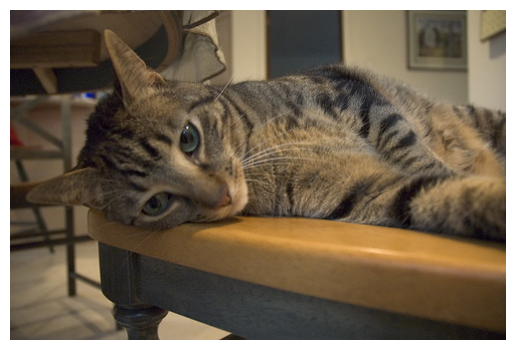

In [358]:
show_random_sample("cat");

And of a fish:

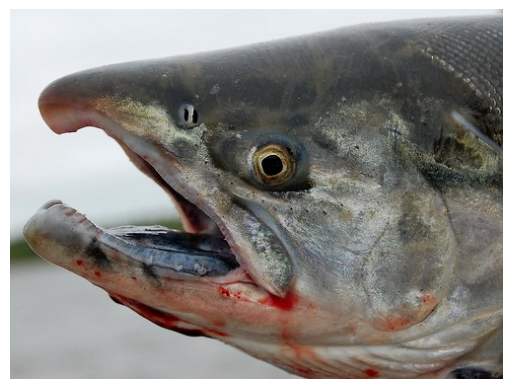

In [359]:
show_random_sample("fish");

### Dataset and DataLoader

PyTorch has evolved a set of **standard data-handling conventions** that make working with images, text, audio, or any other modality feel consistent across projects. At the heart of this design are two key abstractions: **datasets** and **data loaders**.

A dataset is a Python object that knows how to access the data we want to feed into a neural network. It defines how individual samples are retrieved and, optionally, how labels or metadata are associated with them. A dataloader, in turn, takes a dataset and handles the practical mechanics of delivering batches of data to the network. It controls details such as how many samples appear in each batch, whether the data is shuffled, and how many worker processes are used to load data in parallel.

Before digging into data loaders, it helps to understand the dataset abstraction. Any dataset (whether it contains images, audio clips, text tokens, tabular entries, 3D point clouds, or financial time series) can be made compatible with PyTorch as long as it follows a simple interface defined by an abstract Python class:

In [360]:
class Dataset(object):
    
    def __len__(self):
        raise NotImplementedError
    
    def __getitem__(self, index):
        raise NotImplementedError

The idea is simple: to create a custom dataset, we need to provide two methods. The first "__len__" returns the number of samples in the dataset. The second "__getitem__" retrieves a single sample and returns it in the form "(tensor, label)". During training, the data loader repeatedly calls "__getitem__" to fetch individual samples, convert them into tensors, and supply them to the neural network.

In practice, this means that "__getitem__" must contain the logic for loading a data point, for example  reading an image from disk, transforming it into a tensor, and returning it together with its label. This works well, but it’s also something developers end up writing again and again. Since this pattern is so common, it’s natural to ask whether PyTorch can help streamline the process and reduce boilerplate.

The **torchvision** package includes a class called **ImageFolder** that does pretty much everything for us, **providing our images are in a structure where each directory is a label** (e.g., all cats are in a directory called cat). Torchvision also allows us to specify a list of **transforms** that will be applied to an image before it gets fed into the neural network. The default transform is to take image data and turn it into a tensor, but we can also add other transforms such as resizing, cropping, flipping, rotating, and normalizing. Here is how we can use ImageFolder to create a dataset for our cats vs. fish images:

In [361]:
import torchvision
from torchvision import transforms

train_data_path = "./data/cat-vs-fish/train/"

transform_sequence = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225] )
])

train_data = torchvision.datasets.ImageFolder(root=train_data_path,
                                              transform=transform_sequence)

In this example, we apply a **sequence of transforms** before feeding the images into the network. The first step is to **resize** every image to 64×64 pixels. GPUs are extremely efficient when processing inputs of uniform size, but real-world datasets typically contain images at many different resolutions. Standardizing the size improves computational efficiency and simplifies the model architecture.  Here we resize the images to 64×64 purely for convenience, so that the first network we build can train quickly. Most standard image-classification architectures use larger input sizes. Larger inputs provide more visual detail for the model to learn from, but they also come with a trade-off: the bigger each image is, the fewer of them we can fit into GPU memory at once, which typically means using smaller batch sizes.

Next, we convert each image into a tensor, and then we **normalize** it using a predefined mean and standard deviation. Normalization is important because neural networks involve repeated multiplications and additions across many layers; keeping the input values within a stable range helps **prevent numerical issues** such as exploding activations or unstable gradients during training. The mean and standard deviation in the example are the standard values computed from the ImageNet dataset. Although we could compute dataset-specific statistics for the cats-versus-fish images, the ImageNet values generally work well in practice and are widely used as reasonable defaults.

The transform pipeline is also **composable**, meaning we can easily insert additional operations for **data augmentation**, such as rotations, flips, or random crops. These augmentations effectively increase the variability of the training set and help the model generalize better.

With our training data ready, we need to prepare the **validation** data in the same way. Why do we need a separate validation set? A major risk in machine learning is **overfitting**, where a model becomes highly accurate on the examples it has seen during training but fails to **generalize** to new, unseen data. To guard against this, we hold out a distinct collection of cat and fish images that never appear in the training set. After each training cycle (or **epoch**), we evaluate the model on this validation set to check whether its performance is holding up on fresh data rather than just memorizing the training samples. We just reuse the transforms chain instead of having to define it once again:

In [362]:
val_data_path = "./data/cat-vs-fish/val/"

val_data = torchvision.datasets.ImageFolder(root=val_data_path,
                                            transform=transform_sequence)

In addition to the validation set, we should also prepare a **test set**. While the validation set is used during training to monitor performance and tune hyperparameters, the test set serves a different purpose: it provides an **unbiased, final evaluation** of the model **after** all training and tuning are complete. The test set must contain data that the model has never encountered: not during training, and not during validation, so that it reflects how well the model is likely to perform in the real world.

In [363]:
test_data_path = "./data/cat-vs-fish/test/"

test_data = torchvision.datasets.ImageFolder(root=test_data_path,
                                             transform=transform_sequence)

With the datasets defined, we can now construct the corresponding dataloaders. These objects handle the practical details of delivering data to the network: **batching**, **shuffling**, and **loading** samples efficiently, so that training proceeds smoothly:

In [364]:
import torch.utils.data as data

batch_size=64

train_data_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader = data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

The key new parameter in this code is **batch_size**, which controls how many samples are passed through the network before its weights are updated. In theory, we could set the batch size equal to the entire training set so that the network sees all images before each update. In practice, this is almost never done. Smaller batches (called **mini-batches**) use far less memory and allow the model to update its parameters much more frequently, which typically leads to faster and more stable training. Here we choose a batch size of 64, but this is something worth experimenting with: the optimal value depends largely on how much GPU memory is available. We can also adjust several other parameters, such as whether the data should be shuffled at the start of each epoch, how the dataset should be sampled, and how many worker processes are used to load data in parallel. These options allow us to balance speed, randomness, and resource usage when feeding data to the network.

### Architecture

We’ll begin with a simple **fully connected neural network**. It consists of an **input layer** that processes the flattened image tensors, a **hidden layer** that learns intermediate representations, and an **output layer** whose size matches the number of classes, in this case, two:

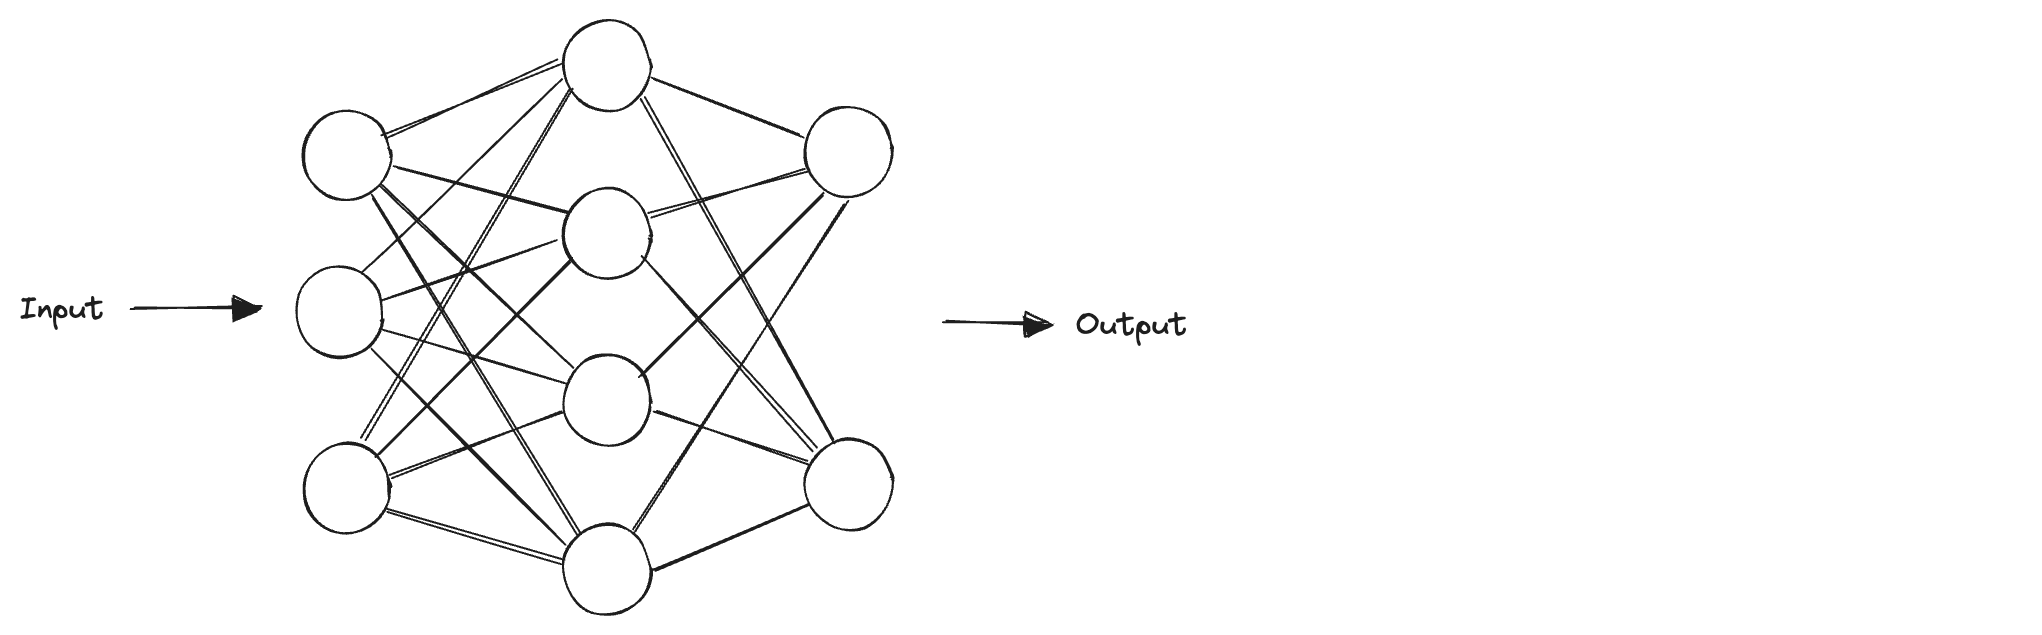


In a fully connected network, every neuron in one layer is linked to every neuron in the next. Each of these connections carries a **weight**, a numerical value that determines how strongly a signal from one neuron contributes to the activation of another. These weights start from random values, and the training process gradually adjusts them so the network can make accurate predictions.

When an input moves through the network, each layer performs a **matrix multiplication** between its weight matrix and the incoming activations (plus a bias term). This produces a new set of values, which are then fed through an **activation function**. Activation functions introduce **non linearity**, which is essential: without them, a deep network (no matter how many layers it contains) would behave like a single large linear transformation and would be unable to model complex patterns.

A widely used activation function is the **ReLU** (Rectified Linear Unit). It is defined as:

$\displaystyle f(z) = \max(0, z)$

ReLU outputs zero for negative inputs and outputs the input value itself when it is positive. This simple operation makes training stable and efficient. Another important activation function is the **softmax** function, often used at the output layer of classification networks:

$\displaystyle \sigma(z)_i = \frac{e^{z_i}}{\sum_j e^{z_j}}$

Softmax converts a vector of arbitrary real numbers into a set of values between 0 and 1 that sum to 1, effectively turning them into probabilities. It also accentuates differences between values, helping the network produce a clear preference for one class over the others. This is why softmax is commonly used as the final step in multi-class classification, it forces the model to make a definite, interpretable prediction.

Building a neural network in PyTorch feels natural for Python developers. We create our model by subclassing **torch.nn.Module** and defining two methods: "__init__", where we **declare the layers**, and "forward", where we **describe how the data flows through those layers**:

In [365]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We create an instance of the SimpleNN:

In [366]:
simplenet = SimpleNet()

This code defines the simple fully connected neural network that flattens the 64×64×3 image into a 12.288 element vector, passes it through two ReLU-activated hidden layers, and uses a final linear layer to produce two output for classification. The sizes of the hidden layers are mostly arbitrary, except for the final layer, which must output 2 units, one for each of our classes (cat and fish). As a general principle, we prefer **the dimensionality to shrink** as we move deeper into a fully connected network. By reducing the dimensionality, we force the network to compress the information and **learn abstract representations**, ideally capturing features such as shapes, edges, fins, or tails that help distinguish the classes.

Once the network produces a prediction, we can compare it to the true label to determine how accurate it was. However, we need more than a simple right-or-wrong signal, PyTorch requires a numeric measure of **how far off** the prediction is. This is provided by a **loss function**, which quantifies the error and guides the network during training.

### Loss Function and Optimizer

Loss functions are a central component of any deep learning model. They provide the numerical signal that tells PyTorch **how wrong** a prediction is and in which direction the network’s weights should be adjusted during training. Without a loss function, the model would have no guidance about how to improve. PyTorch includes a wide range of loss functions suitable for most tasks (classification, regression, sequence modeling, and more) and it also allows us to implement our own when working in highly specialized domains. In the example, we use **CrossEntropyLoss**, the standard choice for multiclass classification problems, like distinguishing between cats and fish. Conceptually, cross-entropy measures how well the predicted probability distribution matches the true distribution:

$\displaystyle \text{CrossEntropyLoss}(y, \hat{y}) = - \sum_{i} y_i \log(\hat{y}_i)$

For a two-class problem, the true label is typically encoded so that the correct class has probability 1 and the others have 0; the loss becomes small when the model assigns a high probability to the correct class.

Another common loss function is **MSELoss** (Mean Squared Error), widely used for regression tasks where the goal is to predict a continuous value. It computes the average squared difference between predicted and actual values:

$\displaystyle \text{MSELoss}(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

Cross-entropy is ideal for classification because it penalizes confident wrong predictions heavily, while MSE is suited for numerical prediction tasks where we care about the magnitude of the error.

**Training** a neural network means repeatedly passing data through the model, measuring how far its predictions deviate from the true labels using a loss function, and then **adjusting the network’s weights** to reduce that loss. The component responsible for updating the weights is called an **optimizer**. Its job is to decide how each parameter should move in order to make the model’s predictions more accurate over time. A useful way to picture this process is to imagine the loss function as a landscape of hills and valleys, and the optimizer as a marble rolling downhill, trying to reach the lowest possible point (**minimum**) where the model makes the fewest mistakes. At each step, the optimizer looks at the **gradient**, which tells it the direction of steepest descent, and adjusts the weights accordingly. In a one-dimensional case (a single weight), this can be visualized as:

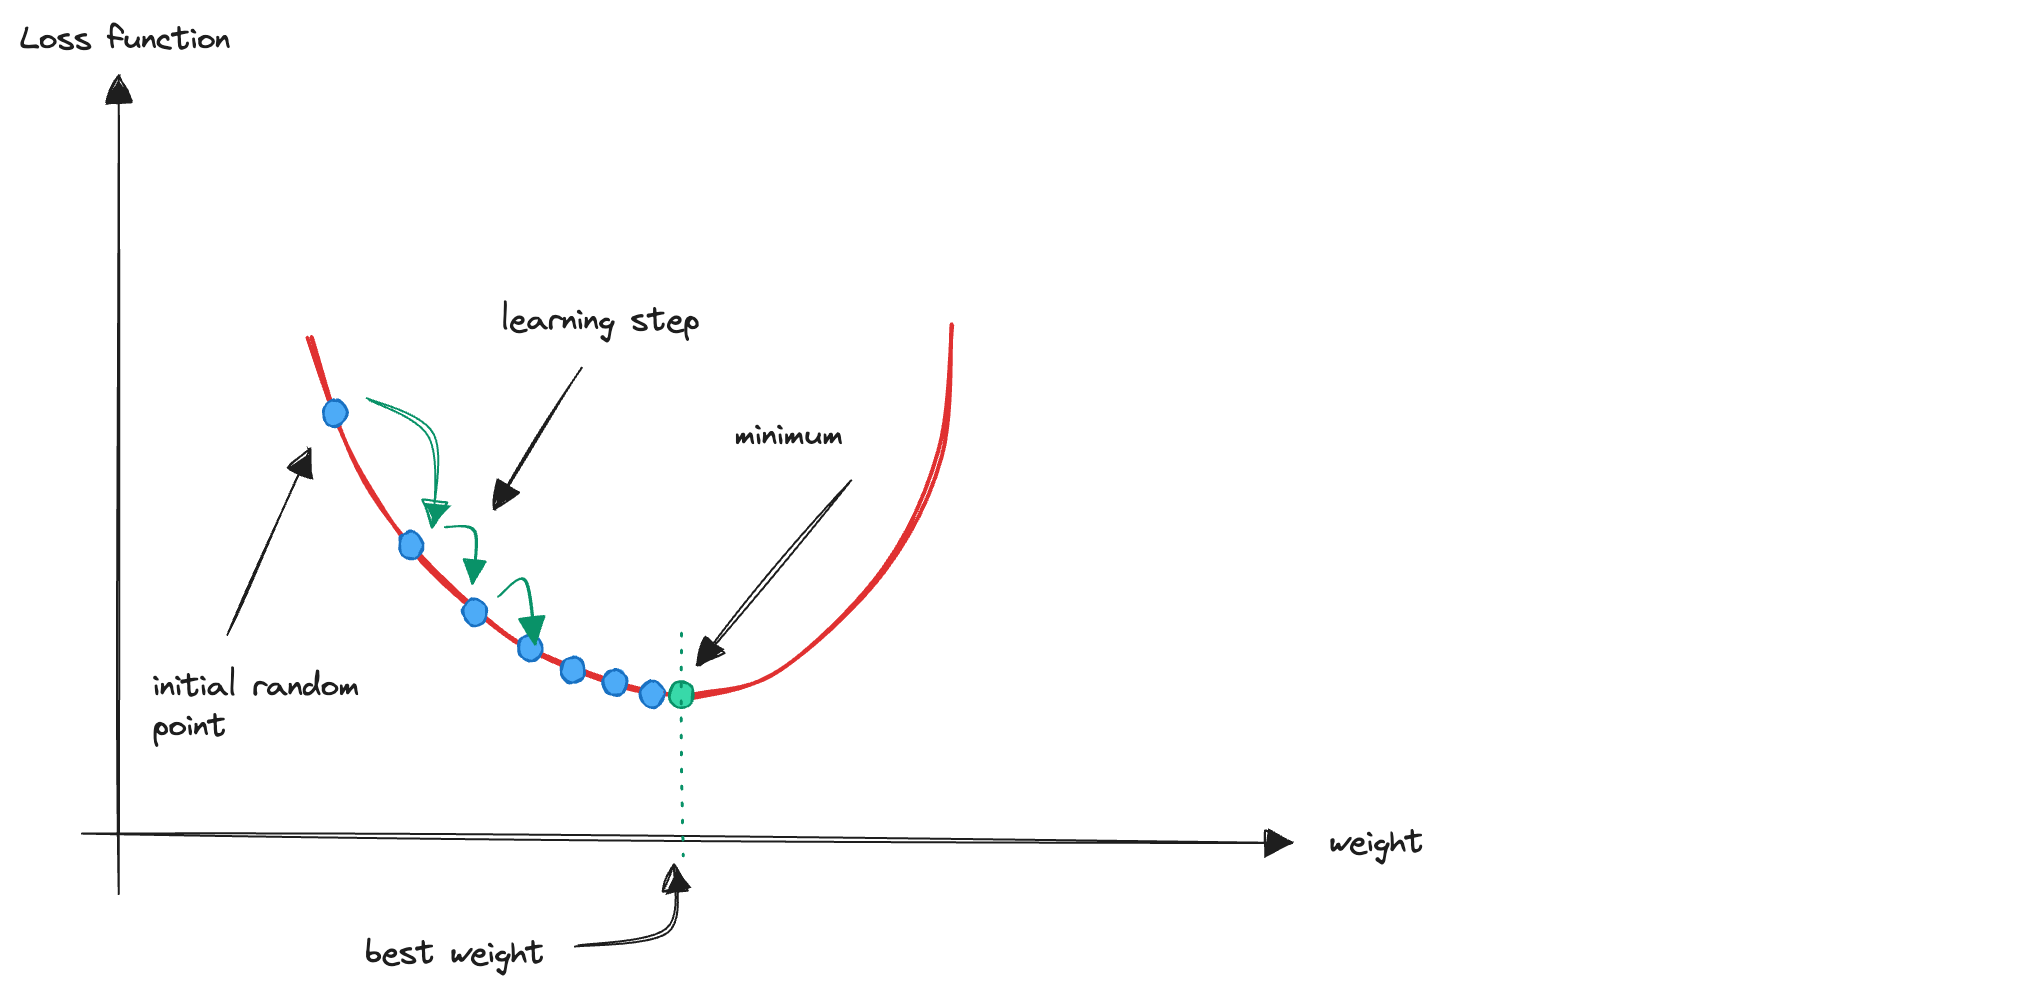

However, two challenges arise. The first is the problem of **local minima**, sometimes the marble gets stuck in a "dip" that is not the lowest point overall. The gradients suggest it has nowhere lower to go, even though a deeper valley exists elsewhere:

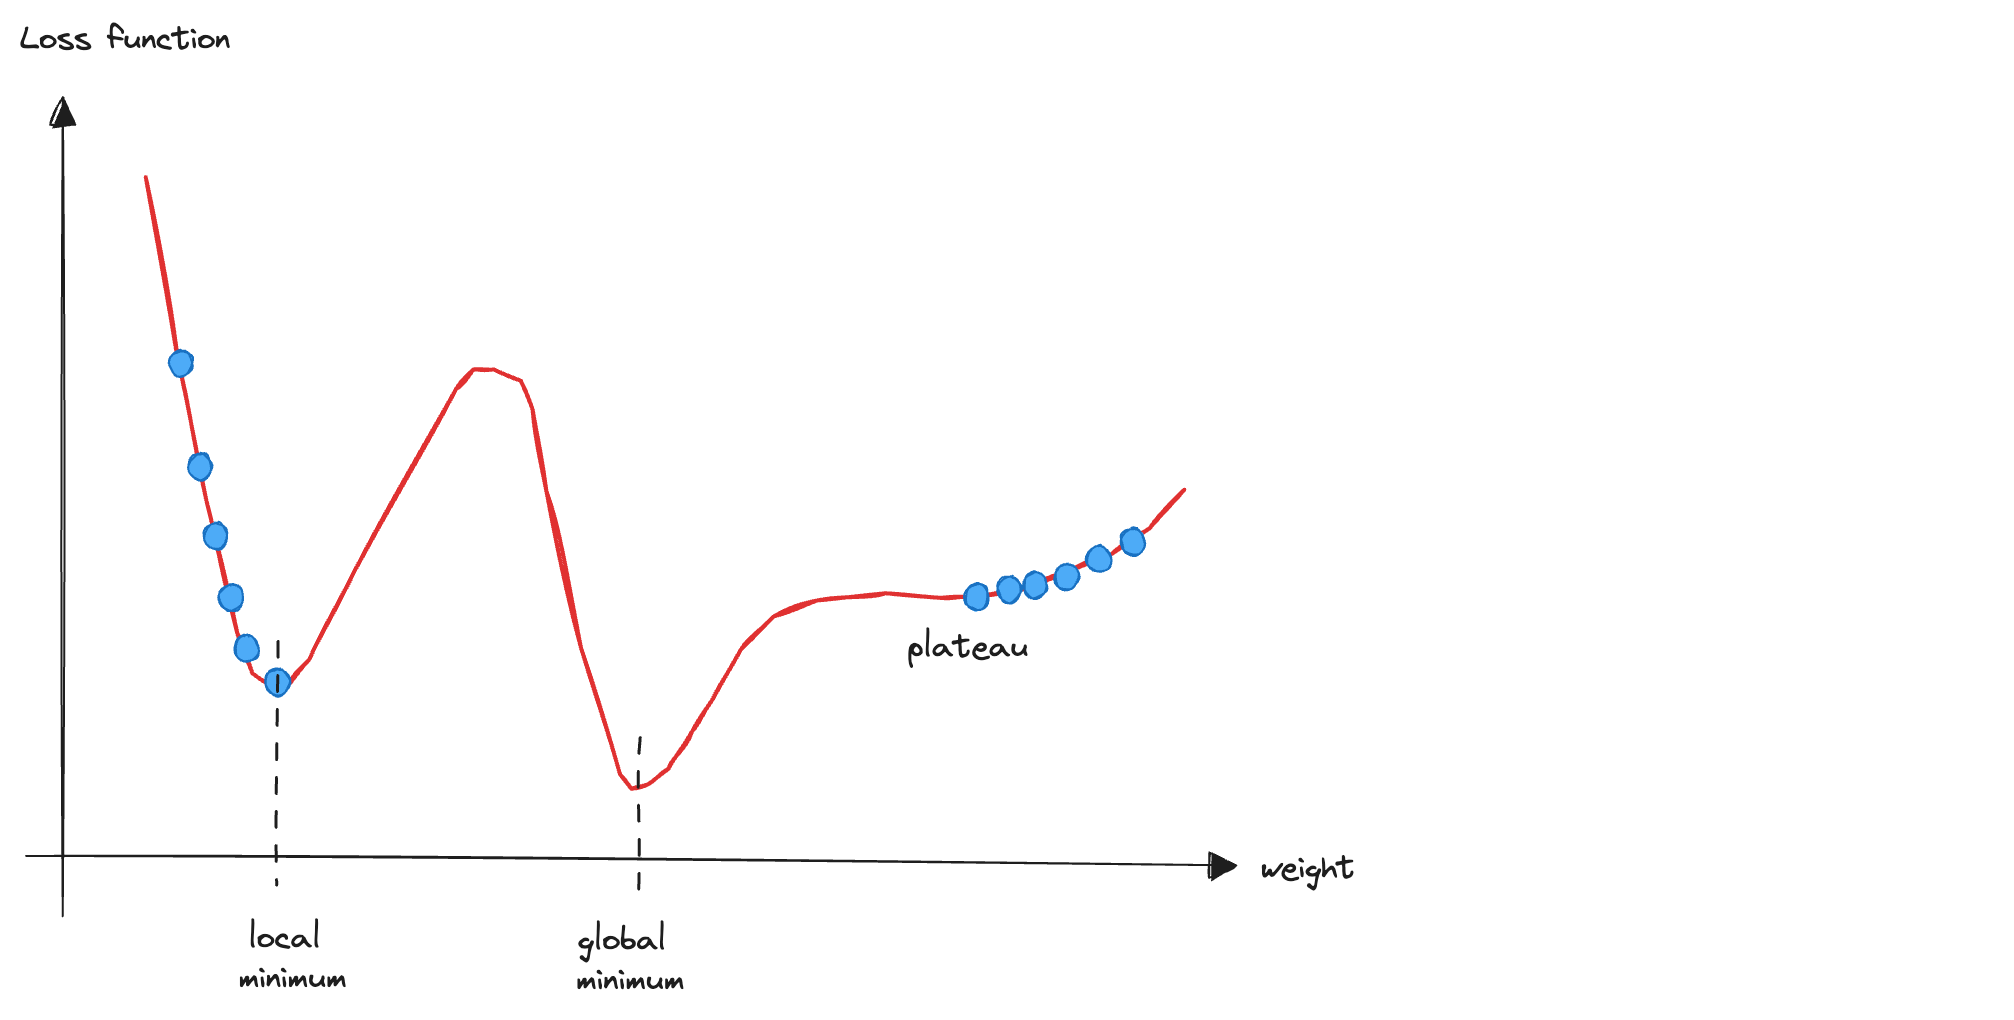

The second is the **learning rate**, if the optimizer takes steps that are too large, it may overshoot the lowest point and bounce around chaotically. If the steps are too small, training becomes slow or stagnates. This step size is called the **learning rate**, and tuning it is essential for efficient training:

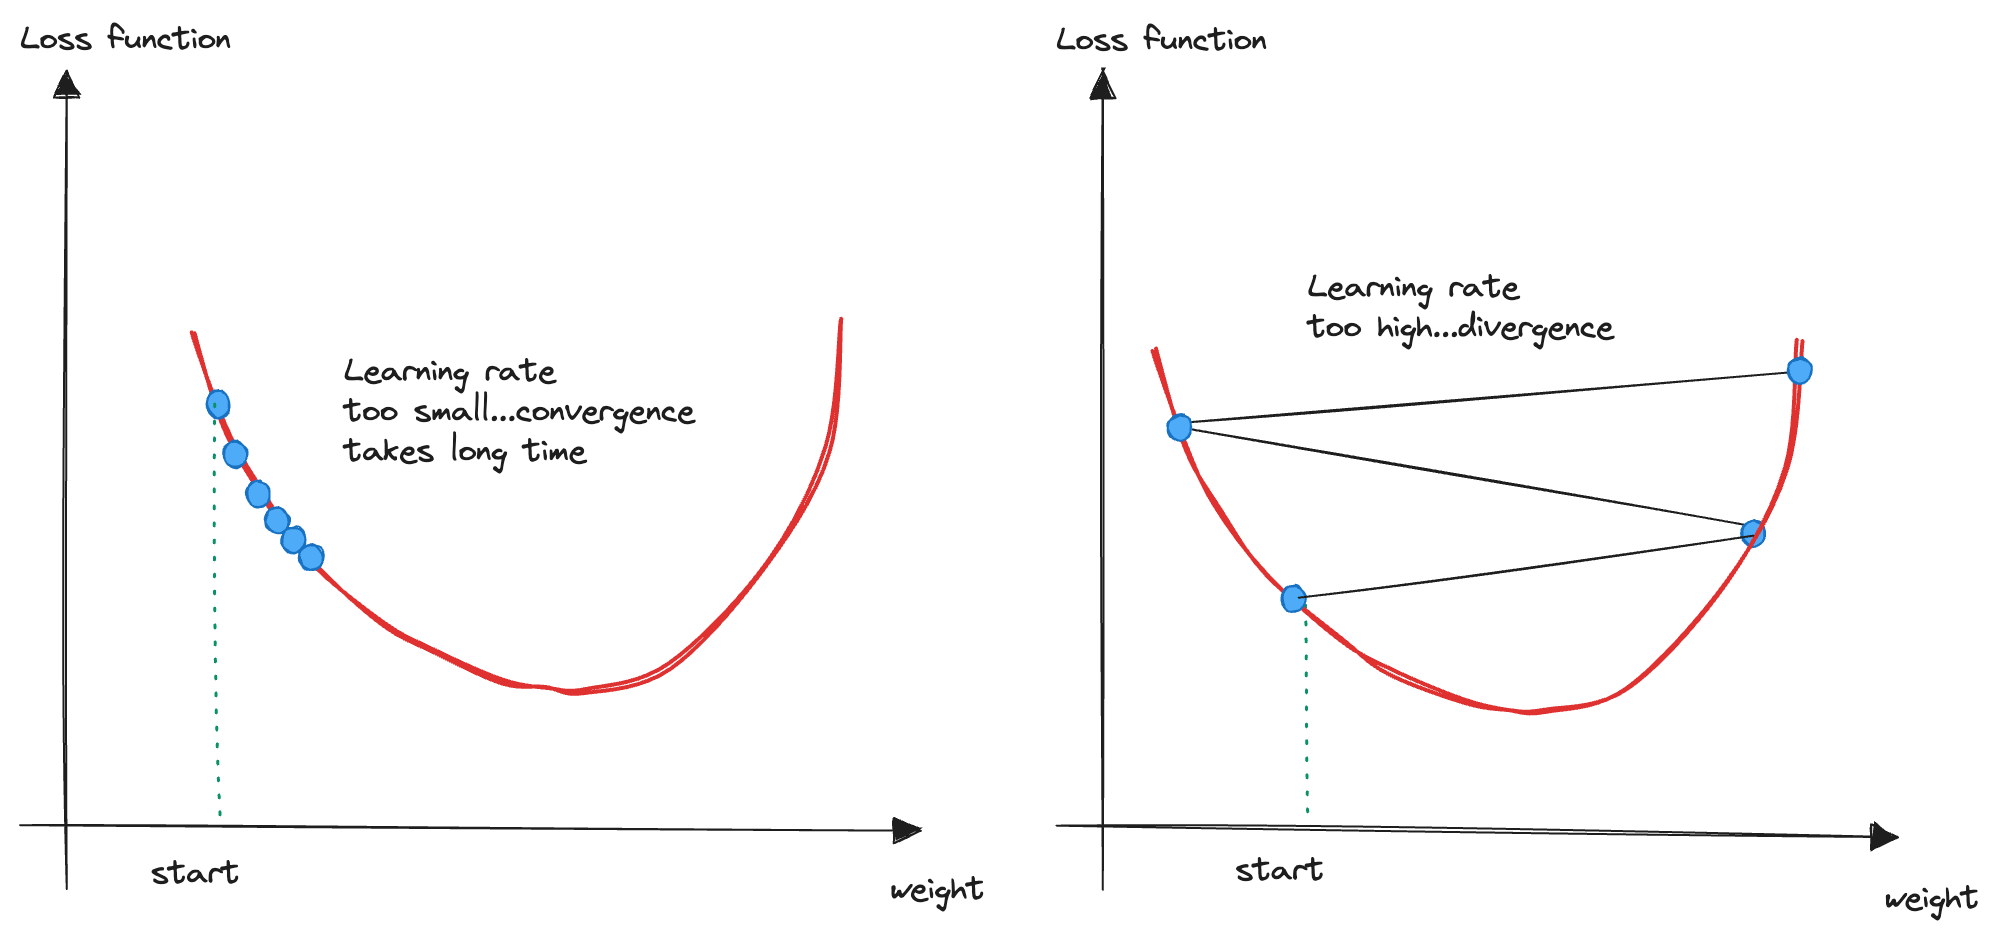


One classic way to avoid getting stuck and to improve generalization is the **stochastic gradient descent (SGD)**: instead of using the entire dataset to compute the gradient, we use a mini-batch of samples. The randomness introduced by these mini-batches helps the optimizer escape shallow local minima and often leads to better performance. While SGD is the traditional workhorse of machine learning, deep learning benefits from more advanced optimizers that **adapt their behavior dynamically**. PyTorch includes several such optimizers, including **AdaGrad**, **RMSProp**, and **Adam**. Adam is especially popular because it maintains separate, adaptive learning rates for each parameter based on how its gradients have behaved in the past. Empirically, Adam tends to converge faster and more reliably than SGD on many deep learning tasks.Creating an Adam optimizer in PyTorch is straightforward. We pass it the parameters of our network (obtained through "simplenet.parameters()") along with a chosen learning rate, for example 0.001:

In [367]:
import torch.optim as optim

optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

### Training Loop

Now we can put everything together into a training loop. The training loop is the heart of the learning process, where the model iteratively improves its performance by adjusting its weights based on the data it sees:

In [368]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    # Move the model to device
    model = model.to(device)
    
    # Run the loop for the specified number of epochs
    for epoch in range(epochs):

        # Initialize running losses
        training_loss = 0.0
        valid_loss = 0.0
    
        # --- Training Phase ---

        # Set model to training mode
        model.train()
        
        # Training loop
        for batch in train_loader:

            # Zero the gradients
            optimizer.zero_grad()

            # Get the inputs and targets from the batch
            inputs, target = batch

            # Move data to the specified device
            inputs = inputs.to(device)
            target = target.to(device)

            # Forward pass
            output = model(inputs)

            # Compute loss
            loss = loss_fn(output, target)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate training loss
            training_loss += loss.item()
        
        # Average training loss
        training_loss /= len(train_loader)

        # --- Validation Phase ---


        # Set model to evaluation mode
        model.eval()

        # Count correct predictions
        num_correct = 0
        num_examples = 0
        
        # Validation loop

        with torch.no_grad(): # Disable gradient computation
            for batch in val_loader:

                # Get the inputs and targets from the batch
                inputs, targets = batch
                
                # Move data to the specified device
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                output = model(inputs)
                
                # Compute loss
                loss = loss_fn(output,targets)

                # Accumulate validation loss
                valid_loss += loss.item()

                # Check predictions
                pred = output.argmax(dim=1)   
                correct = (pred == targets)
                
                # Accumulate number of correct predictions
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]

            # Average validation loss    
            valid_loss /= len(val_loader)

        # --- Reporting ---

        # Print epoch statistics
        print('Epoch: {}, ' \
              'Training Loss: {:.2f}, ' \
              'Validation Loss: {:.2f}, ' \
              'accuracy = {:.2f}'.format(epoch+1, 
                                         training_loss,
                                         valid_loss, 
                                         num_correct / num_examples),
                                         end='\n')


The training loop is fairly easy to follow, but a few important details are worth pointing out. Each iteration begins by taking a batch of data from the training set, handled automatically by the data loader. We feed the batch through the model to obtain predictions, compute the loss by comparing those predictions with the true labels, and then call **backward() to compute the gradients of that loss with respect to the model’s weight**s. After that, **optimizer.step() uses those gradients to update the weights**, exactly as described in the previous section. But what about **zero_grad()**? By default, PyTorch **accumulates** gradients: every call to backward()adds new gradients to whatever is already stored. This is useful for certain advanced techniques, but not for standard training. If we didn’t reset the gradients at the start of each batch, the optimizer would end up using a mix of the current batch’s gradients and all previous batches’ gradients, which would make training behave unpredictably and almost certainly fail. Calling zero_grad() ensures that each weight update is based only on the gradients from the current batch Once this function is defined, training simply consists of calling it with the appropriate parameters:

In [369]:
train(model=simplenet, 
      optimizer=optimizer,
      loss_fn=torch.nn.CrossEntropyLoss(), 
      train_loader=train_data_loader,
      val_loader=val_data_loader,
      epochs=20,
      device="mps")

Epoch: 1, Training Loss: 0.65, Validation Loss: 0.47, accuracy = 0.78
Epoch: 2, Training Loss: 0.38, Validation Loss: 0.57, accuracy = 0.70
Epoch: 3, Training Loss: 0.23, Validation Loss: 0.49, accuracy = 0.81
Epoch: 4, Training Loss: 0.18, Validation Loss: 0.66, accuracy = 0.76
Epoch: 5, Training Loss: 0.12, Validation Loss: 0.62, accuracy = 0.72
Epoch: 6, Training Loss: 0.11, Validation Loss: 0.62, accuracy = 0.75
Epoch: 7, Training Loss: 0.07, Validation Loss: 0.77, accuracy = 0.73
Epoch: 8, Training Loss: 0.05, Validation Loss: 0.79, accuracy = 0.75
Epoch: 9, Training Loss: 0.04, Validation Loss: 0.91, accuracy = 0.74
Epoch: 10, Training Loss: 0.02, Validation Loss: 0.82, accuracy = 0.72
Epoch: 11, Training Loss: 0.01, Validation Loss: 0.81, accuracy = 0.72
Epoch: 12, Training Loss: 0.01, Validation Loss: 0.88, accuracy = 0.76
Epoch: 13, Training Loss: 0.01, Validation Loss: 0.87, accuracy = 0.75
Epoch: 14, Training Loss: 0.00, Validation Loss: 0.93, accuracy = 0.72
Epoch: 15, Trai

The network was trained for some epochs and we get a printout of the model’s accuracy on the validation set at the end of each epoch. Looking at these results, we can see a clear story unfold. During the first few epochs, the model is **genuinely learning: the training loss falls quickly, the validation loss also drops**, and the accuracy climbs. For such a simple fully connected network working with small images, that’s a perfectly respectable level of performance. The model is discovering useful visual patterns—edges, shapes, perhaps even cues like tails or fins, that allow it to distinguish cats from fish reasonably well. After some epochs, however, the behavior begins to shift. **The training loss continues to decrease steadily, but the validation loss stalls and then gradually starts rising**. The validation accuracy stops improving and hovers around the same values, sometimes dipping slightly. This divergence between training and validation performance is the classic signature of **overfitting**. The model is becoming increasingly **specialized** in recognizing the particular images it has seen during training, while **losing its ability to generalize** to new, unseen examples. This outcome isn’t surprising. Fully connected networks have a large number of parameters relative to the amount of data. Without built-in constraints, the model eventually **starts "memorizing" the training set** rather than **learning robust features**.

There are several ways to push back against this. Adding some form of **regularization** (dropout, weight decay, or stronger data augmentation) can help the model stay more general. **Early stopping** is another simple and effective approach: training could reasonably be halted around the first few epochs, when the validation loss is at its minimum. And, of course, the most impactful change would be to switch to a **convolutional architecture**. Even a small CNN is far better suited for image data and would likely outperform this fully connected model while overfitting less.

###  Inference

Now that our model has been trained, the final step is to **use it to make predictions** Specifically, we can feed in an image and have the network tell us whether it thinks the image shows a cat or a fish. The following short Python snippet loads an image from disk, processes it in the same way as the training data, and prints out the model’s predicted class:

In [370]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch

labels = ['cat', 'fish']

def predict_random_image(model, transform_sequence, device="cpu"):

    # Paths for test folders
    test_root = "./data/cat-vs-fish/test"
    cat_path  = os.path.join(test_root, "cat")
    fish_path = os.path.join(test_root, "fish")

    # Pick a random class folder
    class_folder = random.choice([cat_path, fish_path])

    # Pick a random file inside that folder
    filename = random.choice(os.listdir(class_folder))

    # Full image path
    img_path = os.path.join(class_folder, filename)

    # Load image
    img = Image.open(img_path)

    # Show the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()

    # Apply transforms
    img_tensor = transform_sequence(img)

    # Add batch dimension
    img_tensor = img_tensor.unsqueeze(0)

    # Move to device
    img_tensor = img_tensor.to(device)

    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        prediction = output.argmax(dim=1).item()

    print("Predicted label:", labels[prediction])
    print("Ground truth folder:", os.path.basename(class_folder))

    return labels[prediction]


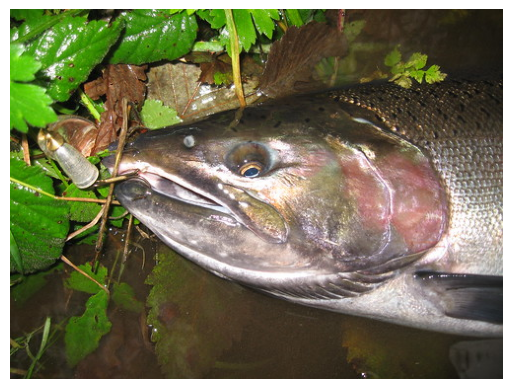

Predicted label: fish
Ground truth folder: fish


In [371]:
predict_random_image(simplenet, transform_sequence, device="mps");

Most of the code is straightforward: we simply reuse the transform pipeline from earlier to convert the image into the format expected by the network. One subtle point, however, is that our model was trained on **batches** of images, which means **it expects a 4D tensor** where the first dimension is the **batch size**. When we want to classify a single image, we don’t naturally have a batch, so we create one of size 1 by calling **unsqueeze(0)**. This adds a new leading dimension and turns our single image into a batch containing exactly one item.

Once the image is in the correct shape, making a prediction is simply a matter of passing it through the model. The **output is a vector of class scores**, and we need to determine which class has the highest value. While we could manually compare the values, PyTorch provides a convenient **argmax()** function that returns the index of the maximum element. We then map that index to our label list and print the predicted class.


### Generalization error estimation

To estimate the generalization error of our trained model, we can evaluate its performance on the test set that we held out earlier. This involves running the model on the test data and calculating metrics:

In [372]:
def evaluate(model, test_loader, loss_fn, device="cpu"):
    # Set model to evaluation mode
    model.eval()

    # Move model to device
    model.to(device)

    # Initialize metrics
    total_loss = 0.0
    num_correct = 0
    num_samples = 0

    # Evaluation loop
    with torch.no_grad():
        for inputs, targets in test_loader:

            # Move data to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_fn(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Prediction
            preds = outputs.argmax(dim=1)

            # Update metrics
            num_correct += (preds == targets).sum().item()
            num_samples += targets.size(0)

        # Compute average loss and accuracy
        avg_loss = total_loss / len(test_loader)
        accuracy = num_correct / num_samples

        # Print results
        print(f"Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    
    return avg_loss, accuracy

In our example, we obtain:

In [373]:
evaluate(simplenet, test_data_loader, torch.nn.CrossEntropyLoss(), device="mps");

Test Loss: 1.1792, Accuracy: 0.7562


### Saving and Loading

Once we are satisfied with a model performance (or simply need to pause and resume work later), we can **save its current state** using PyTorch’s built-in **serialization utilities**. PyTorch relies on Python’s pickle format under the hood, and saving is done with **torch.save()**, while loading a saved model is handled by **torch.load()**. To preserve the model’s learned parameters and architecture, you can save its state dictionary as follows:

In [374]:
torch.save(simplenet, "./data/simplenet")

And we can reload as follows:

In [375]:
simplenet = torch.load("./data/simplenet",  weights_only=False)

Models can be saved to disk at any point during training and later reloaded to resume exactly where you left off. 

## Convolutional Neural Networks

A fully connected (or feed-forward) neural network has the theoretical ability to approximate any function (universal approximation theorem),however, that theorem doesn’t tell us **how efficiently** such a network can learn the function we care about, nor how much data, training time, or parameter tuning will be required. In practice, relying on a dense network for image tasks is **rarely ideal**. Images have **structure** (spatial patterns, local correlations, repeated features) that fully connected layers simply do not exploit. This is where **Convolutional Neural Networks (CNNs)** come in. CNNs are explicitly designed to take advantage of the 2D spatial nature of images. Their use of **convolutional filters**, **shared weights**, and **local receptive fields** makes them far more efficient at detecting edges, shapes, and texture, the kinds of features that matter for visual recognition. As a result, CNNs form the foundation of nearly all high-performing image classifiers in modern computer vision.

In the cat-versus-fish problem, switching from a fully connected architecture to a convolutional one gives us immediate benefits. A CNN can learn meaningful visual features more quickly, requires fewer parameters, and almost always achieves higher accuracy. In the next step, we’ll build a simple CNN for our classification task and demonstrate how much faster and more effective it is compared to the earlier fully connected model.

### Convolution

The basic support for CNN in PyTorch is provided by the **torch.nn.Conv2d** layer, which implements a **2D convolution operation**. To understand how it works, imagine a simple grayscale image. Such an image can be represented as a 2D array of pixel intensities (x pixels wide and y pixels high) where each entry contains a value between 0 and 255 (for an 8-bit image), indicating how dark or bright that pixel is:

In [376]:
# A tiny 4x4 grayscale image
image = torch.tensor([
    [ 10,  11,  9,  3],
    [  2, 123,  4,  0],
    [ 45, 237, 23, 99],
    [ 20,  67, 22, 255]
], dtype=torch.float32)

Next, we introduce a **filter**, also known as a **convolutional kernel**. This is a small matrix (typically much smaller than the image itself) that we slide across the image to detect specific patterns or features. For example, here is a simple 2×2 filter:

In [377]:
# A simple 2×2 convolutional filter
filter = torch.tensor([
    [ 1., 0.],
    [ 1., 0.]
])

To generate the output of a convolution, we **slide the smaller filter across the original image**, much like moving a magnifying glass over a sheet of paper. At each position, the filter overlaps **a small patch of the image**, and we compute a value based on that overlap. To compute the output at each position, we simply multiply each element of the image patch by the corresponding element of the filter and then sum all those products. For example:

$\displaystyle \text{Output} = (10*1) + (11*0) + (2*1) + (123*0) = 10 + 0 + 2 + 0 = 12$

Once we’ve computed this value, we slide the filter to the next location and repeat the process. In the following figure, we illustrate the calculation of a generic pixel of an image:

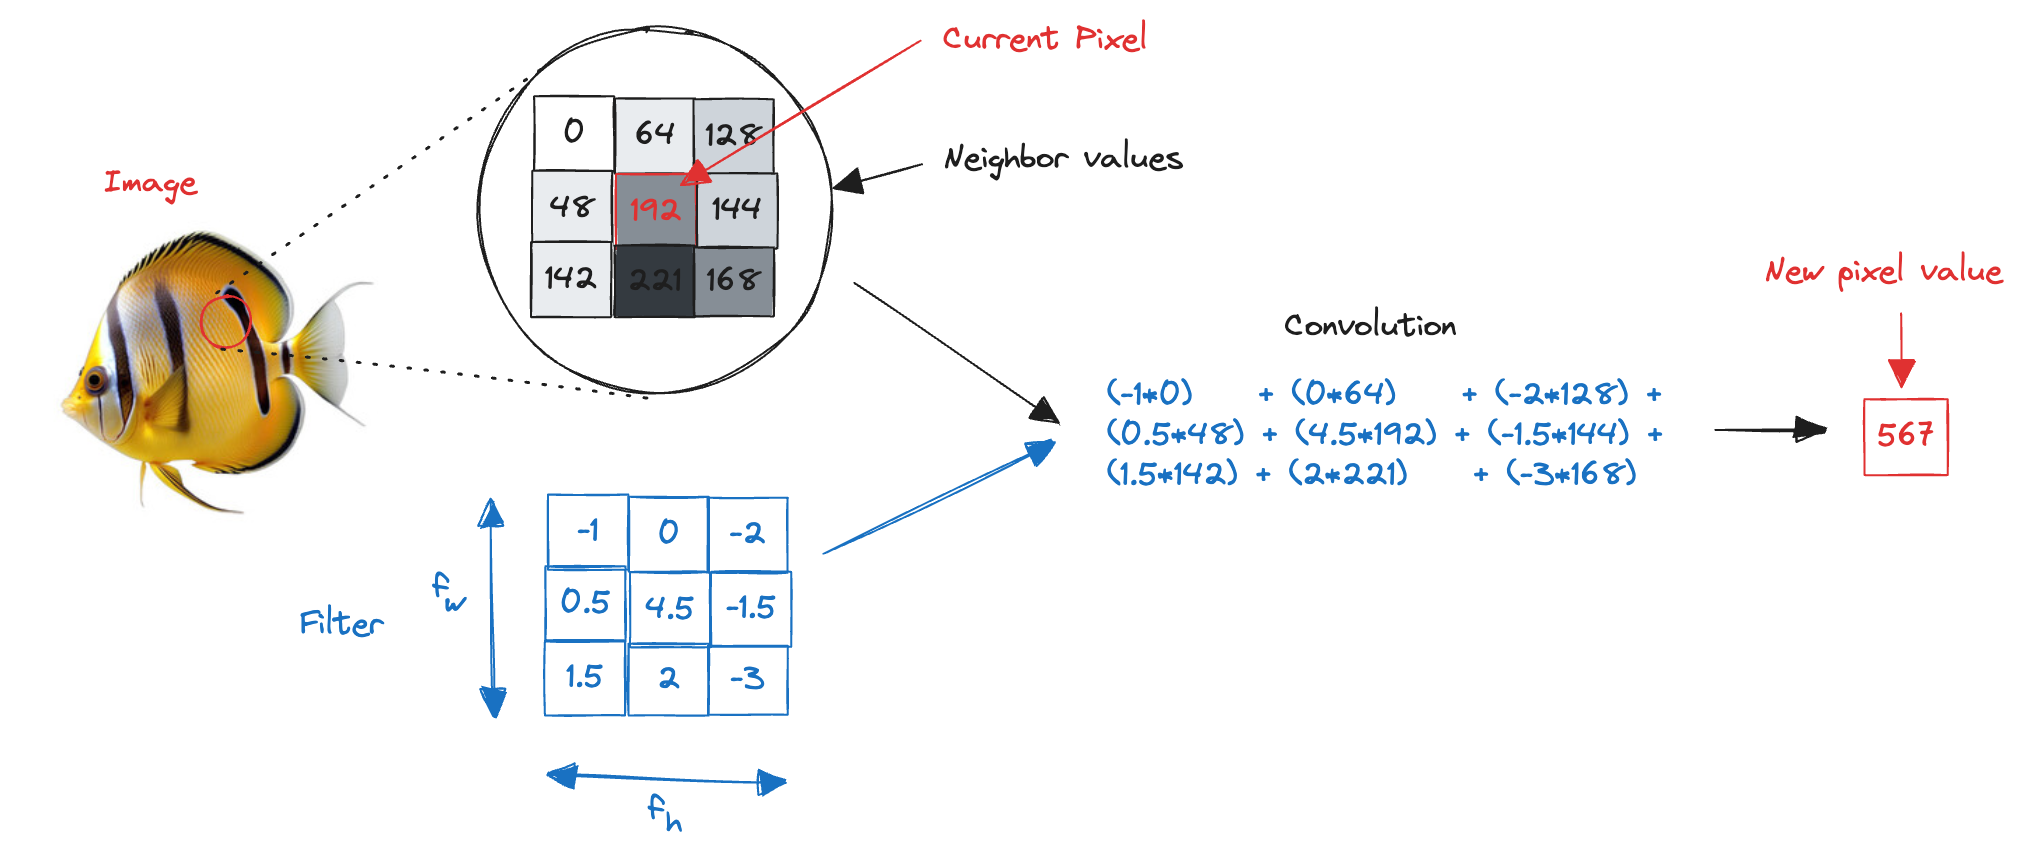

We can implement this using the two tensor defined earlier for the first patch of the image:

In [378]:
# Extract the top-left patch
patch1 = image[0:2, 0:2]
print("Top-left image patch:")
print(patch1)

# Elementwise multiplication + sum
output1 = torch.sum(patch1 * filter)
print("\nFirst output value:", output1.item())

Top-left image patch:
tensor([[ 10.,  11.],
        [  2., 123.]])

First output value: 12.0


Having done that, we **move the filter across** and begin again. But how much should we move the filter? In this case, we move the filter across by 2, meaning that our second calculation is:

In [379]:
# Second patch
patch2 = image[0:2, 2:4]
output2 = torch.sum(patch2 * filter)

# Third patch
patch3 = image[2:4, 0:2]
output3 = torch.sum(patch3 * filter)

# Fourth patch
patch4 = image[2:4, 2:4]
output4 = torch.sum(patch4 * filter)

At the end of this process, we end up with a new 2D array called a **feature map** or **activation map**. This map highlights where certain features (as defined by the filter) are found in the original image. By using different filters, we can create multiple feature maps, each capturing different aspects of the image, such as edges, textures, or specific shapes.

In [380]:
# Combine outputs into a 2x2 feature map
feature_map = torch.tensor([
    [output1.item(), output2.item()],
    [output3.item(), output4.item()]
])

print("\nFeature map:\n", feature_map)


Feature map:
 tensor([[12., 13.],
        [65., 45.]])


We have several ways to control how a convolution operates on an image. We can choose the size of the filter, decide how far it moves between applications, and determine what should happen at the edges when the filter would otherwise extend beyond the image. These design choices significantly influence both what the layer learns and how the output is shaped. Two of the most important controls are **stride** and **padding**. The stride specifies how much the filter shifts as it slides across the image. With a stride of 1, the filter moves one pixel at a time, examining every possible position and capturing fine-grained detail. A stride of 2 skips every other pixel, effectively reducing the output’s spatial resolution and speeding up the computation, since fewer positions need to be evaluated. Padding deals with the borders of the image. Because a filter cannot extend past the edges, a convolution without padding naturally reduces the size of the output. Padding solves this by adding extra pixels (typically zeros) around the outside of the image. This gives the filter room to operate even at the boundaries and allows us to preserve the original dimensions. 

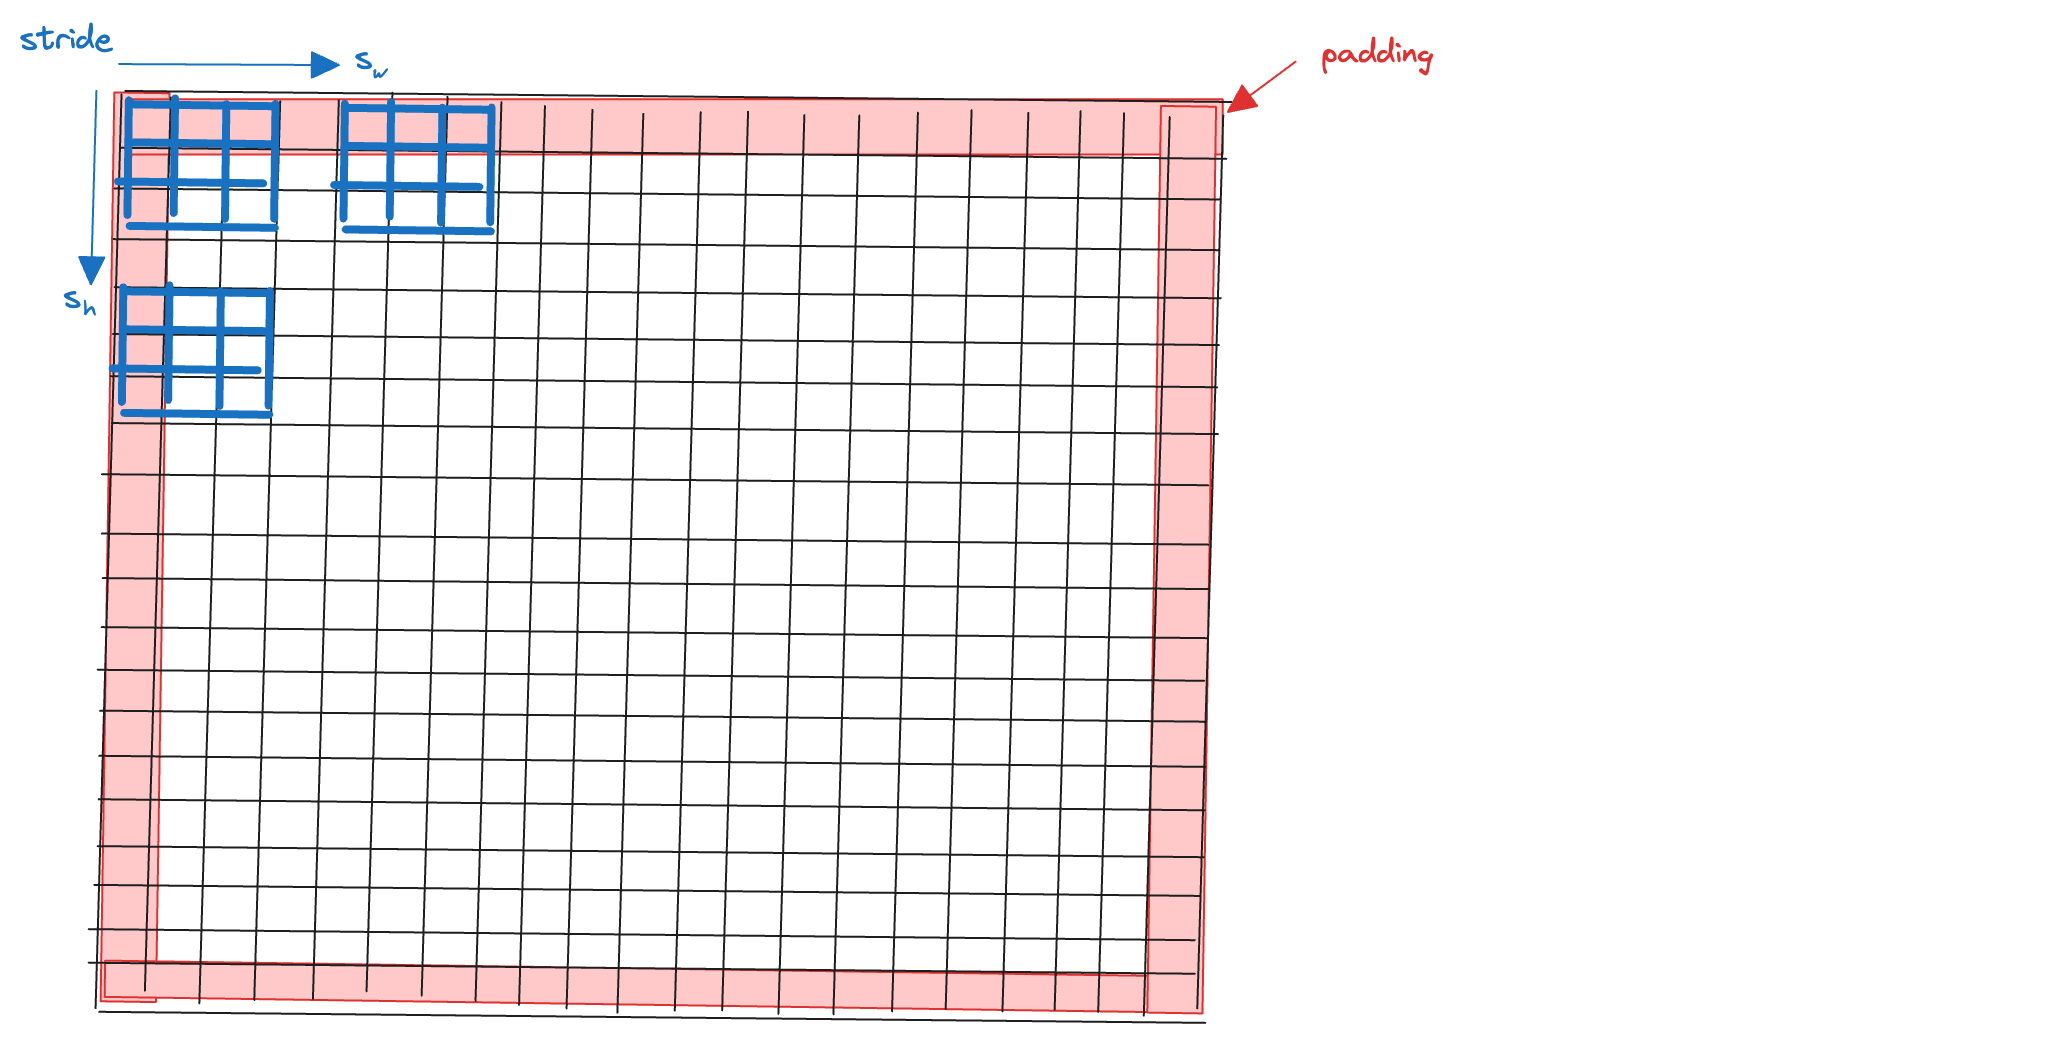


During training, the network **learns the values inside each filter**, allowing different filters to detect different patterns (like edges, textures, shapes, and increasingly complex features). The A Conv2d layer takes several parameters: the **number of input channels** (for RGB images, this is 3), the **number of output channels** (which determines **how many filters the layer learns**), the **kernel size** (the dimensions of each filter), the **stride** (how far the filter moves at each step), and **padding** (how much zero to add around the input):

In [381]:
# A simple Conv2d layer:
# - 1 input channel  (e.g., grayscale image)
# - 1 output channel (one learned filter)
# - 3×3 kernel
conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)

### Pooling

After convolutional layers, we often apply a second type of operation called **pooling**. Pooling layers don’t learn any parameters; instead, they reduce the spatial size of the feature maps in a simple, deterministic way. The idea is to take a small region of the feature map and replace it with a **single summarized value**. This helps the network **focus on the most important patterns** while discarding unnecessary detail. Pooling serves several purposes at once. It makes the representation **smaller and more manageable**, which reduces the number of computations in deeper layers. It also introduces a degree of **translation invariance**: if an object in an image shifts slightly, the pooled representation does not change much, making the network more robust to small movements. The most common type is **max pooling**, where we slide a small window (for example, 2×2 pixels) across the feature map and, at each position, simply take the **maximum** value inside the window. Another option is **average pooling**, which replaces each region with its average value rather than the maximum; this yields smoother, less aggressive downsampling.

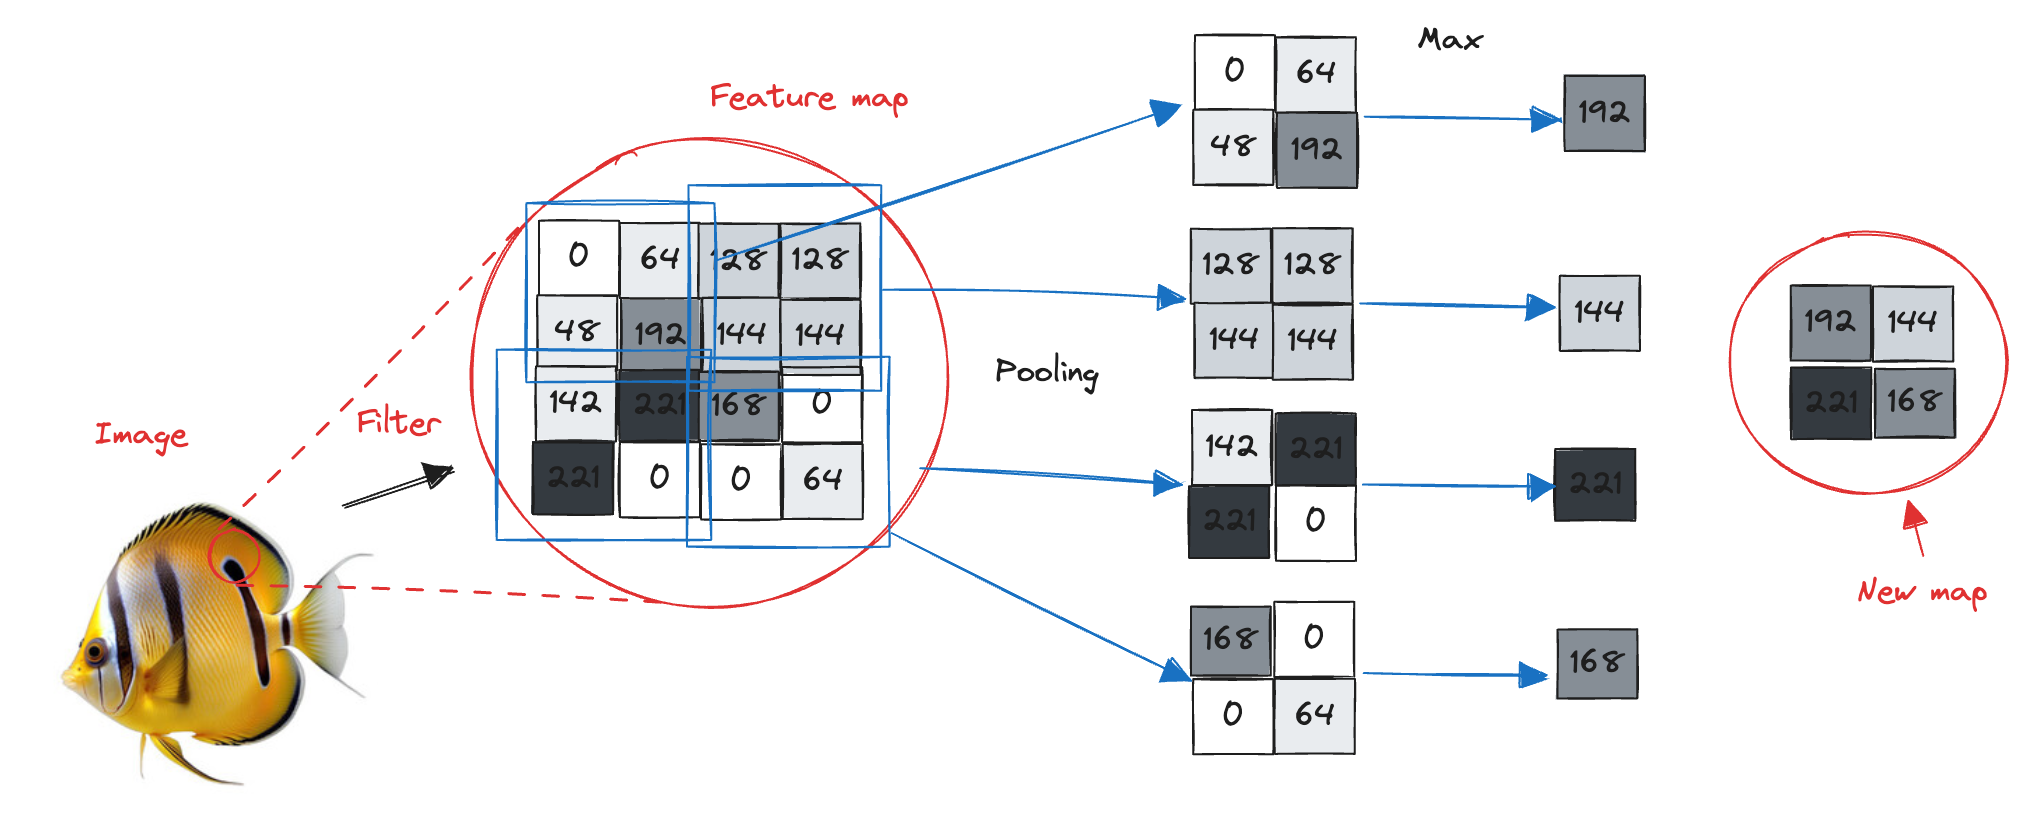


In PyTorch, pooling layers are easy to use. A 2×2 max-pooling layer with stride 2 (one of the most common configurations) can be created with:


In [382]:
# A 2x2 max pooling layer with stride 2
pool = nn.MaxPool2d(kernel_size=2, stride=2)

Given an input feature map, this operation will cut its height and width in half. For example, a feature map of size 16×16 becomes 8×8 after pooling. Pooling layers are **typically placed after convolutional layers**, allowing the network to progressively shrink the spatial dimensions while building deeper, more abstract representations of the input. Later layers can then focus on the "what" rather than the "where", which is especially important for image classification tasks.

PyTorch also offers **AdaptiveMaxPool** and **AdaptiveAvgPool** layers, which automatically adjust to the size of the incoming tensor. Unlike regular MaxPool or AvgPool layers (where the output size depends on the input dimensions and the kernel settings) adaptive pooling lets us **specify the exact output size we want**, and PyTorch computes whatever kernel and stride are needed to produce it. This makes our models more **flexible** because they no longer depend on a fixed input image size.

### Dropout

One of the perennial challenges in training neural networks is preventing **overfitting**, the tendency of a model to memorize the training data rather than learn patterns that generalize to new examples. A great deal of deep learning research focuses on methods to improve generalization, and one of the simplest and most effective of these techniques is the **Dropout** layer.

The idea behind Dropout is almost mischievously simple: during training, **we randomly "turn off" a fraction of the neurons in a layer**: 

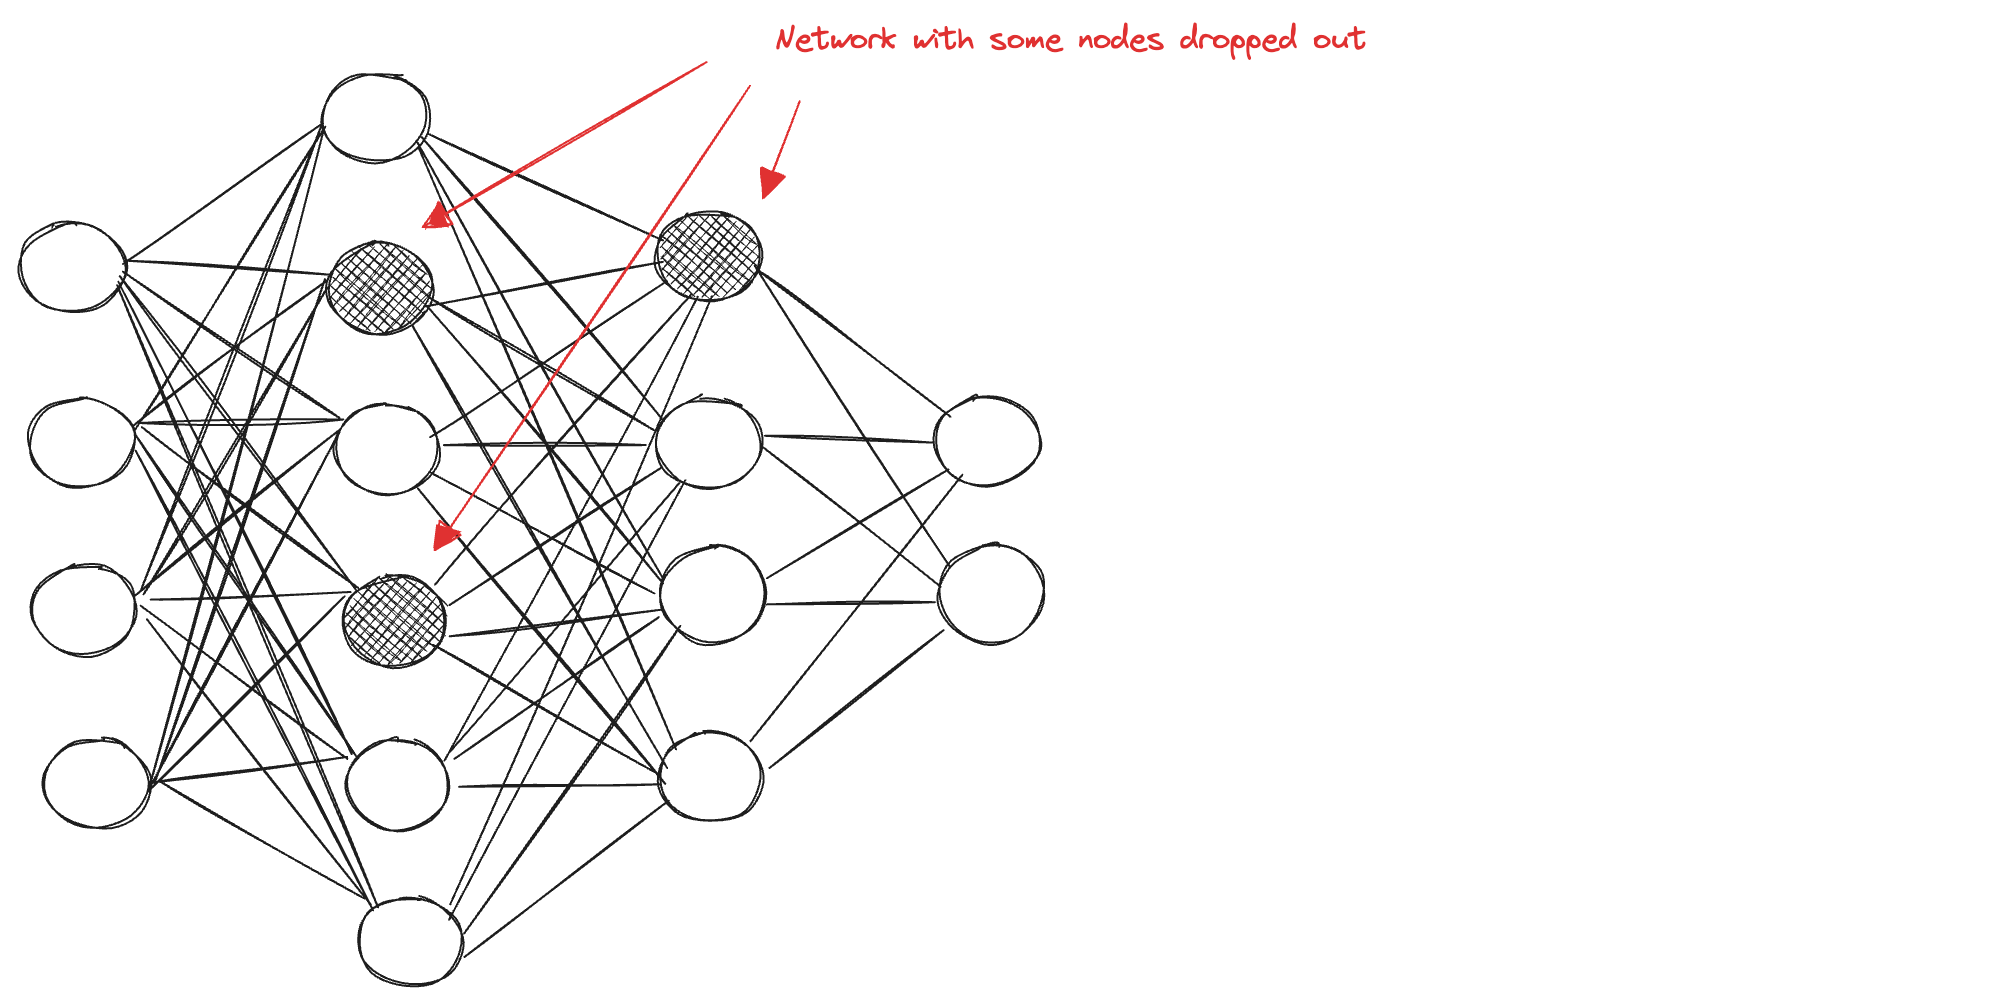

These temporarily disabled **neurons do not participate in the forward pass**, and more importantly, they **do not receive weight updates** during backpropagation. Because different neurons are dropped at each training step, **the network is forced to rely on multiple pathways** through the model **rather than over-specializing on any single one**. This randomness acts as a **powerful regularizer** and encourages the network to learn more robust, generalizable representations.  PyTorch supports Dropout through the **torch.nn.Dropout** layer, which integrates seamlessly into any model:

In [383]:
# Dropout layer that drops 50% of the inputs
drop = nn.Dropout(p=0.5)

It’s important to note that Dropout should be active **only during training**. Using it at inference time would arbitrarily remove parts of the network’s learned reasoning ability, which would obviously harm performance. PyTorch handles this automatically: when the model is in evaluation mode, Dropout layers simply pass their inputs through unchanged, ensuring consistent predictions during testing or deployment.

### Architecture

Now we can put togher all the building blocks and create a simple CNN architecture. It follows the classic design of many high-performing convolutional neural networks by dividing the model into two major components: a deep **convolutional feature extractor** and a **fully connected classifier**.

The first part of the network, consists of **several convolutional layers stacked one after another**, each followed by nonlinear activation functions and occasional pooling operations. The early layers use larger kernels and strides to quickly reduce the spatial resolution while capturing **broad, low-level patterns** such as edges, color contrasts, and simple textures. As we move deeper into the sequence of convolutions, the layers use smaller kernels (typically 3×3) and more filters, allowing the network to represent **increasingly complex and abstract visual structures**. By the time the input reaches the final convolutional layers, the representation no longer resembles raw pixel data but instead **encodes high-level visual cues—shapes, contours, or object-specific features that are useful for classification**. 

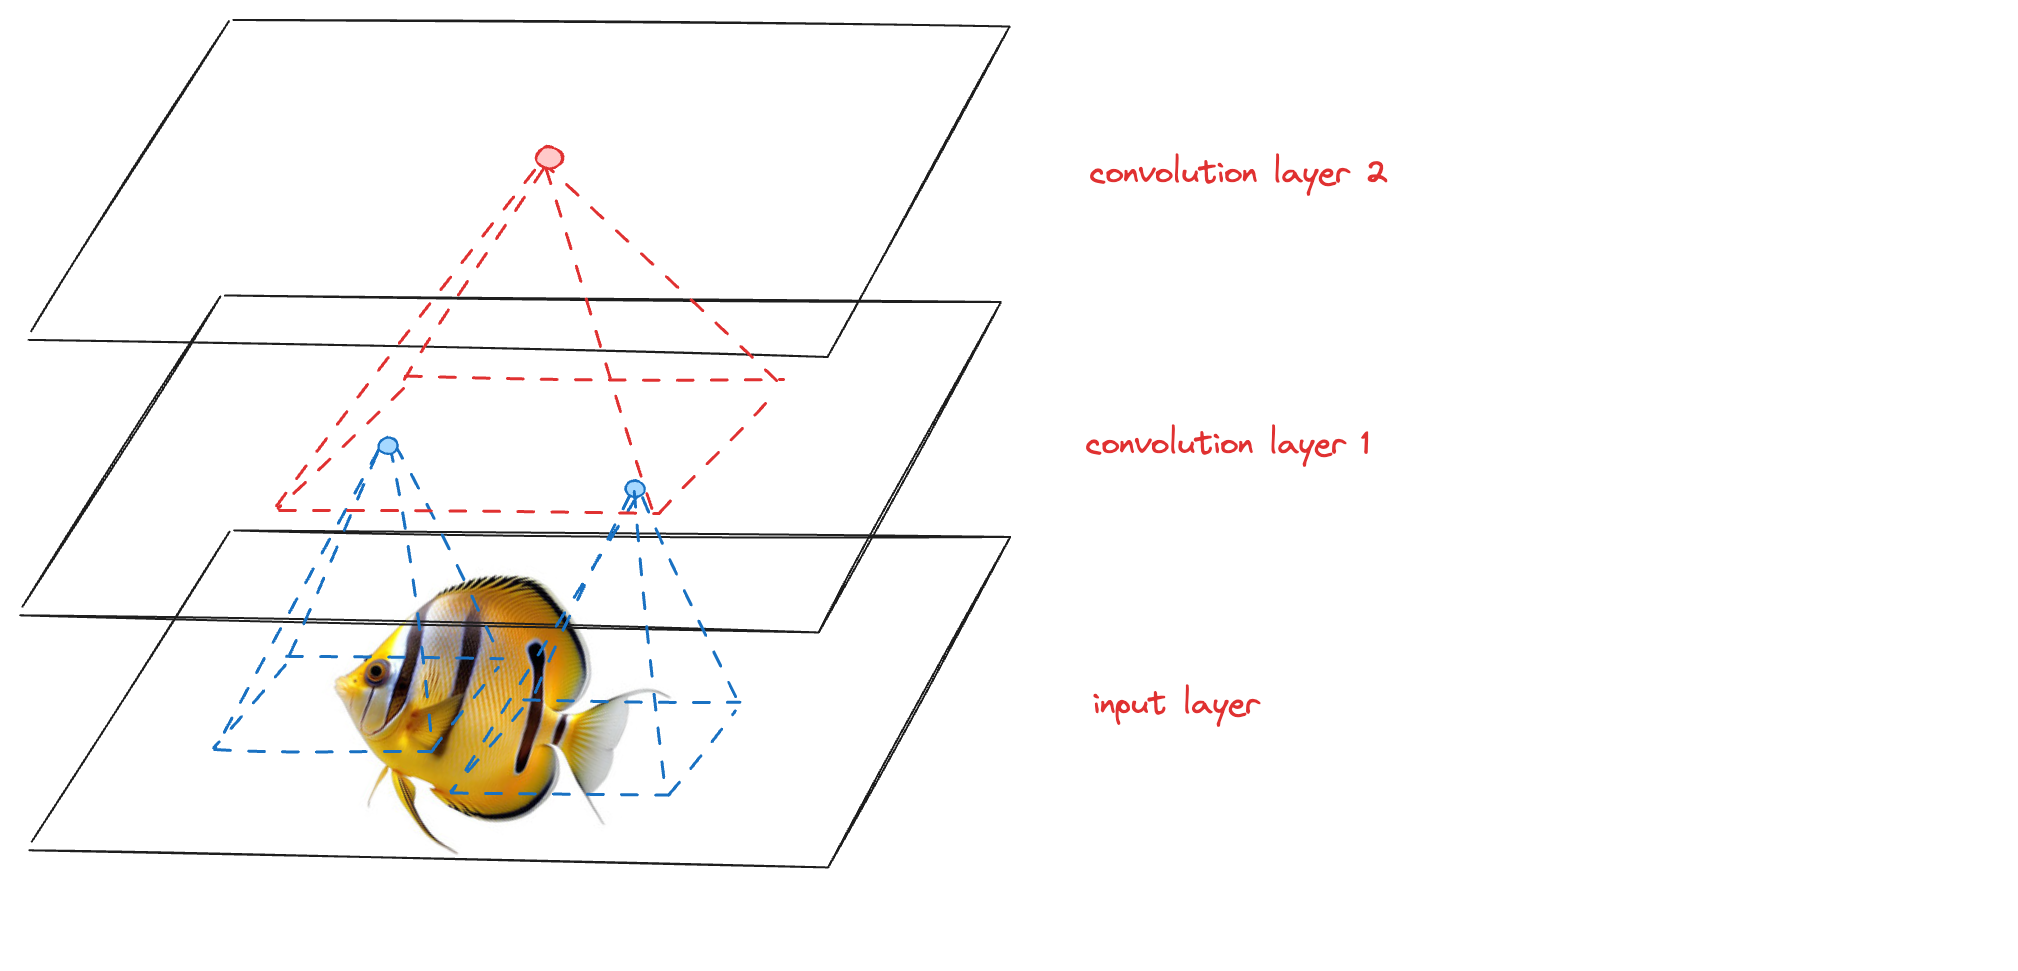

Max-pooling layers inserted between convolutional blocks downsample the feature maps, reducing computational cost and making the learned representation more robust to small shifts or distortions in the image.

Once the convolutional part has extracted a rich set of spatial features, the network transitions to the **fully connected layers**. Before entering this stage, an **adaptive average pooling layer** ensures that the size of the feature maps is standardized, regardless of the input image dimensions. This is especially helpful because it **decouples** the convolutional feature extractor from the fixed-size requirement of linear layers. After pooling, the 3D feature maps are flattened into a 1D vector and fed into a series of large linear layers. These layers behave much like the classifier at the end of a traditional multilayer perceptron: they **take the high-level features learned by the convolutional stack and combine them to make a final decision** about the class of the input image.

Dropout layers are inserted between the fully connected layers to reduce overfitting, encouraging the network to learn more robust combinations of features rather than memorizing the training set. The final linear layer outputs a score for each class, from which the prediction is derived.

Together, these two components (deep convolutional feature extraction followed by dense classification) form a powerful architecture that can handle complex image data far more effectively than a purely fully connected network.

Notice the use of **nn.Sequential()**, this allows to create a **chain of layers**. When we use one of these chains in forward(), the input goes through each element of the array of layers in succession. We can use this to break our model into more **logical arrangements**. 

In [384]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        # --- Convolutional feature extractor ---
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Adaptive pooling for flexibility with input size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        # --- Fully connected classifier ---
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

We create the nework ant its optimizer as follows:

In [385]:
simplecnn = SimpleCNN()
optimizer_cnn = optim.Adam(simplecnn.parameters(), lr=0.001)

Now we can train the model using the same training loop as before:

In [386]:
train(model=simplecnn, 
      optimizer=optimizer_cnn,
      loss_fn=torch.nn.CrossEntropyLoss(), 
      train_loader=train_data_loader,
      val_loader=val_data_loader,
      epochs=20,
      device="mps")

Epoch: 1, Training Loss: 0.64, Validation Loss: 0.52, accuracy = 0.73
Epoch: 2, Training Loss: 0.52, Validation Loss: 0.35, accuracy = 0.84
Epoch: 3, Training Loss: 0.49, Validation Loss: 0.40, accuracy = 0.84
Epoch: 4, Training Loss: 0.46, Validation Loss: 0.46, accuracy = 0.82
Epoch: 5, Training Loss: 0.42, Validation Loss: 0.38, accuracy = 0.84
Epoch: 6, Training Loss: 0.40, Validation Loss: 0.45, accuracy = 0.79
Epoch: 7, Training Loss: 0.37, Validation Loss: 0.35, accuracy = 0.81
Epoch: 8, Training Loss: 0.33, Validation Loss: 0.44, accuracy = 0.81
Epoch: 9, Training Loss: 0.31, Validation Loss: 0.23, accuracy = 0.91
Epoch: 10, Training Loss: 0.28, Validation Loss: 0.30, accuracy = 0.85
Epoch: 11, Training Loss: 0.24, Validation Loss: 0.56, accuracy = 0.77
Epoch: 12, Training Loss: 0.22, Validation Loss: 0.29, accuracy = 0.85
Epoch: 13, Training Loss: 0.21, Validation Loss: 0.26, accuracy = 0.90
Epoch: 14, Training Loss: 0.18, Validation Loss: 0.69, accuracy = 0.75
Epoch: 15, Trai

We can see that the model is learning effectively and reaches **strong performance**. In the early epochs the network improves quickly, reducing both training and validation loss, and capturing the distinction between the two classes. After few epochs the model reaches its best generalization ability, with the lowest validation loss and the highest, most stable accuracy. After this point, however, the training loss continues to fall while the validation loss becomes increasingly unstable, clear evidence of **overfitting**, where the model begins to memorize training details rather than improving its ability to generalize. Overall, this is excellent performance for a small CNN trained from scratch on a limited dataset, and with **early stopping** we would capture the model at its most accurate and most robust state. We can see the model in action by testing it on a few images from the test set:

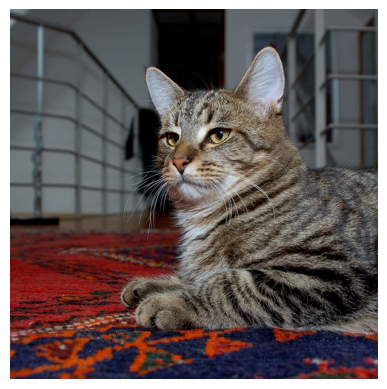

Predicted label: cat
Ground truth folder: cat


In [387]:
predict_random_image(simplecnn, transform_sequence, device="mps");

Finally, we can evaluate the model on the test set to estimate its generalization error:

In [388]:
evaluate(simplecnn, test_data_loader, torch.nn.CrossEntropyLoss(), device="mps");

Test Loss: 0.5781, Accuracy: 0.8375


The test-set evaluation confirms a pattern consistent with what we observed during training and validation: the model performs well but shows some **signs of limited generalization**. The model has learned useful features but is slightly overfitting to the training and validation data, a conclusion reinforced by the relatively high test loss, which suggests the model is less confident or less calibrated when encountering completely unseen images. In practical terms, the model generalizes reasonably well but could benefit from techniques such as **data augmentation**, **regularization**, or a **slightly richer architecture** to close the gap between validation and test performance. We can save the trained model for future use:

In [389]:
torch.save(simplecnn, "./data/simplecnn")

## Optimizations

Optimizing learning in deep neural networks involves far more than choosing an architecture, techniques such as transfer learning, selecting an effective learning rate and augmenting training data can dramatically improve both performance and generalization.

### Transfer Learning

Defining a model **from scratch** every time we want to use one would quickly become tedious, especially because CNN architecctures have existed since the 1990s (LeNet-5 being an early example used for handwritten digit recognition), their modern success only became possible once GPUs made large-scale training practical. Over roughly the last decade, several **landmark architectures** have defined the evolution of deep learning for image classification. Moreover, training these models from scratch requires **large labeled datasets** (often millions of images) and **substantial computational resources** (days or weeks of GPU time). Fortunately, we can leverage the power of these pre-trained models through a technique called **transfer learning**. Transfer learning involves taking a model that has already been trained on a large dataset (like ImageNet) and adapting it to a new, often smaller dataset. The idea is that the early layers of these models have already learned to detect general features (edges, textures, shapes) that are useful across many visual tasks. By reusing these learned features, we can significantly reduce the amount of data and training time required to achieve good performance on our specific task. PyTorch **includes implementations of many popular CNN models** directly in the torchvision library:

**AlexNet (2012)** was the breakthrough model that changed the field. It dramatically outperformed all competitors in the ImageNet competition, cutting the top-5 error rate to 15.3%, far better than the next best model. AlexNet introduced or popularized now-standard ideas such as ReLU activations, MaxPool layers, and Dropout, while demonstrating that deep networks could be effectively trained on GPUs. 

**GoogLeNet/Inception (2014)** advanced the field by introducing the Inception module, which applies multiple convolution sizes in parallel to capture both coarse and fine details within the same layer. A 1×1 convolution serves as a bottleneck to reduce computation before larger kernels are applied. The full GoogLeNet stacks nine such modules and achieves a much lower parameter count than AlexNet while reaching a top-5 error of 6.67%, approaching human performance.

**VGG (2014)**, developed at Oxford, took a different approach by using a very simple and uniform design: deep stacks of 3×3 convolutions followed by large fully connected layers. VGG-16 achieved strong results (8.8% top-5 error), proving that depth alone can yield significant improvements. However, its simplicity comes at the cost of size: VGG-16 has around 138 million parameters, making it much heavier than GoogLeNet. Despite this, VGG remains widely used, particularly in style-transfer applications.

**ResNet (2015)** from Microsoft introduced the concept of **residual connections**, allowing the input of a block to be added to its output. This innovation solved the vanishing-gradient problem and enabled extremely deep networks. ResNet-152 achieved a top-5 error of 4.49%, and ensembles went even lower, surpassing human performance.

After ResNet, many architectures have built on these ideas. Some like **DenseNet** push depth further, while others such as **SqueezeNet** and **MobileNet** target lightweight models for mobile devices. An entirely new direction is **neural architecture search (NAS)**, where algorithms design CNNs automatically; Google’s NASNet achieved a top-5 error of 3.8%, one of the best results at the time.

For example, creating an AlexNet model tailored to a two-class problem is as simple as:

In [390]:
from torchvision.models import alexnet

alexnet_model = alexnet(num_classes=2)

We can ntrain this model using the same training loop as before, however it is slightly bigger and more complex model, so the size of the dataset can be a limiting factor. PyTorch also provides **ready-to-use** definitions for VGG, ResNet, Inception, DenseNet, SqueezeNet, and several other well-known architectures. Beyond just loading the model structure, you can also obtain pretrained weights by calling:

In [391]:
from torchvision.models import AlexNet_Weights

alexnet_model = alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

However, this pretrained model is trained on ImageNet, which has 1000 classes. So we cannot use it directly for our cat-vs-fish problem. We need to adapt it to the different number of classes by **replacing the final classification layer** with a new one that matches our specific task. This process is known as **fine-tuning** or **transfer learning** and allows us to leverage the powerful feature extraction capabilities of these pretrained networks while tailoring them to our unique dataset.

We **keep the pretrained backbone unchanged** and **replace the final classification layer** with a new one matching our number of classes, and freeze the original layers. During training, only the new layers are updated, while the frozen layers continue to provide high-quality features learned from ImageNet. This simple adjustment lets us build a strong classifier with minimal data and computation. In the following we reuse a pretrained ResNet model and adapt it for our two-class cat-vs-fish problem:

In [392]:
from torchvision.models import resnet50, ResNet50_Weights

resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1);

Next, we need to **freeze the pretrained layers** so that their weights remain unchanged during training. In PyTorch, this is done by **disabling gradient computation** for those parameters. Each parameter tensor has a "requires_grad" flag, and setting it to false prevents PyTorch from updating it during backpropagation. Since a model may contain many such parameters, we can conveniently loop through them using the parameters() method:

In [393]:
for name, param in resnet_model.named_parameters():
    param.requires_grad = False

After freezing the pretrained layers, we need to **replace the original classifier with a new one tailored to our task**. Since we want the model to distinguish between cats and fish, we define a fresh classification block. Conveniently, PyTorch’s ResNet implementation exposes its final classification layer as the attribute "fc". This means we can simply overwrite "model.fc" with our custom module:

In [394]:
# Step 1: define the new classifier
new_classifier = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

# Step 2: replace the final layer of the pretrained model
resnet_model.fc = new_classifier

In the code above, we take advantage of the **in_features** attribute to automatically retrieve the number of activations feeding into the final layer (2,048 for ResNet-50). PyTorch layers also expose **out_features**, which tells us how many activations the layer produces. These attributes are extremely useful when building networks modularly: if the output size of one layer doesn't match the expected input size of the next, PyTorch will raise a runtime error.

Once the new classifier is in place, we simply return to our usual training loop. Because the pretrained backbone already encodes rich visual features, we should see accuracy improve dramatically after just a few epochs. PAy attention to the optimizer: since we only want to update the new classification layers, we must pass only their parameters:

In [395]:
optimizer_resnet = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

train(model=resnet_model, 
      optimizer=optimizer_resnet,
      loss_fn=torch.nn.CrossEntropyLoss(), 
      train_loader=train_data_loader,
      val_loader=val_data_loader,
      epochs=20,
      device="mps")

Epoch: 1, Training Loss: 0.56, Validation Loss: 0.48, accuracy = 0.79
Epoch: 2, Training Loss: 0.30, Validation Loss: 0.33, accuracy = 0.88
Epoch: 3, Training Loss: 0.29, Validation Loss: 0.23, accuracy = 0.91
Epoch: 4, Training Loss: 0.28, Validation Loss: 0.28, accuracy = 0.86
Epoch: 5, Training Loss: 0.21, Validation Loss: 0.26, accuracy = 0.89
Epoch: 6, Training Loss: 0.17, Validation Loss: 0.25, accuracy = 0.89
Epoch: 7, Training Loss: 0.16, Validation Loss: 0.25, accuracy = 0.89
Epoch: 8, Training Loss: 0.14, Validation Loss: 0.22, accuracy = 0.89
Epoch: 9, Training Loss: 0.13, Validation Loss: 0.20, accuracy = 0.90
Epoch: 10, Training Loss: 0.14, Validation Loss: 0.31, accuracy = 0.86
Epoch: 11, Training Loss: 0.12, Validation Loss: 0.27, accuracy = 0.88
Epoch: 12, Training Loss: 0.13, Validation Loss: 0.21, accuracy = 0.89
Epoch: 13, Training Loss: 0.14, Validation Loss: 0.25, accuracy = 0.92
Epoch: 14, Training Loss: 0.11, Validation Loss: 0.26, accuracy = 0.87
Epoch: 15, Trai

These results clearly show the power of **transfer learning** compared to training a CNN from scratch. Already in the first epoch, the pretrained ResNet feature extractor gives the model a strong starting point, which would be impossible with a randomly initialized network. Across the training process, validation accuracy consistently stays high, with only occasional dips. This fluctuation is expected because we are training only the final classifier while the rest of ResNet remains frozen; the network is already highly competent at extracting visual features, and the classifier only needs to learn how to map them to "cat" and "fish". The later increase in validation loss indicates some **mild overfitting** of the new classifier head. This happens because the classifier is small, the backbone is fixed, and our dataset is not extremely large. Still, generalization remains solid, and accuracy never collapses. Overall, this training curve represents exactly what we hope to see in transfer learning: **very fast convergence**, **high accuracy**, and **minimal training effort** thanks to the pretrained ResNet backbone. Finally, we can evaluate the model on the test set to estimate its generalization error:

In [396]:
evaluate(resnet_model, test_data_loader, torch.nn.CrossEntropyLoss(), device="mps");

Test Loss: 0.3638, Accuracy: 0.9062


This test result confirms the advantage we gained by switching to transfer learning. The test accuracy is significantly higher than what our scratch-trained CNNs achieved, and it reflects performance on completely unseen data, which means the model has **genuinely learned to generalize the distinction between cats and fish**. The test loss is also reassuring: it indicates that the model’s predictions are not only correct most of the time but also reasonably confident.

### Learning rate

Learning rate is one of the most important hyperparameters in neural network training, yet also one of the hardest to select. Traditional approaches often rely on **trial and error** or **grid search**, testing multiple values and comparing performance on a validation set. Although effective, these methods are slow and inefficient. Another common practice is to reuse **rule-of-thumb values**, such as the frequently cited "3e-4 for Adam", which is a joke among practitioners because it’s so widely used without much justification.

A more systematic alternative is the **learning rate range test**. The idea is simple: during a single epoch, begin with a very small learning rate and gradually increase it with each of N mini-batchs by multiplying it by a constant scaling factor s. This causes the learning rate to sweep through a wide range of values, from tiny to large:

$\displaystyle \eta_0 = \text{init lr}$

$\displaystyle \eta_1 = \eta_0 \cdot s$

$\displaystyle \eta_2 = \eta_1 \cdot s$

$\displaystyle \vdots$

$\displaystyle \eta_{N} = \eta_0 \cdot s^{N}$

So the condition is:

$\displaystyle \text{init lr} \cdot s^{N} = \text{final lr}$

So solving for the scaling factor s:

$\displaystyle s^{N} = \frac{\text{final lr}}{\text{init lr}}$

$\displaystyle s = \left( \frac{\text{final lr}}{\text{init lr}} \right)^{1/N}$

At the same time, we record the training loss at each step. By plotting the loss against the learning rate, we can visually identify the optimal learning rate: it’s typically located just before the loss starts to increase sharply, indicating that the model is beginning to diverge. This method provides a principled way to select a learning rate that is neither too small (leading to slow convergence) nor too large (causing instability). That point provides a principled estimate of a good learning rate for training:

In [397]:
import math

def find_lr(model, train_loader, loss_fn, optimizer,
           init_lr=1e-8, final_lr=10, device="cpu"):
    
    # Move model to device
    model = model.to(device)
    
    # Number of batches
    num_batches = len(train_loader) - 1
    
    # Factor by which to increase LR each batch
    lr_step = (final_lr / init_lr) ** (1 / num_batches)

    # Set starting learning rate
    lr = init_lr
    optimizer.param_groups[0]["lr"] = lr

    # Track best loss, lrs and losses
    best_loss = float("inf")
    lrs = []
    losses = []

    # Set model to training mode
    model.train()
    
    # Loop for finding testing the learning rate
    for batch_idx, (inputs, targets) in enumerate(train_loader):

        # Move data to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute loss
        loss = loss_fn(outputs, targets)

        # Stop early if the loss explodes
        if batch_idx > 1 and loss.item() > 4 * best_loss:
            return lrs, losses

        # Track the best loss seen so far
        if loss.item() < best_loss:
            best_loss = loss.item()

        # Store current LR and loss
        lrs.append(lr)
        losses.append(loss.item())

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        # Update the learning rate for the next batch
        lr *= lr_step
        optimizer.param_groups[0]["lr"] = lr

    return lrs, losses


What happens inside the loop is essentially a normal training step, except that the learning rate is gradually increased after each batch. For every mini-batch, we run a forward pass, compute the loss, and compare it with the best loss seen so far. If the new loss suddenly becomes extremely large (more than four times the current best_loss) we stop the procedure early, because this typically means the model is diverging and the loss is blowing up toward infinity. Otherwise, we record both the loss and the current learning rate, then continue. At the end of each iteration, we multiply the learning rate by the step factor so that it smoothly progresses toward the final learning rate by the end of the loop. We can try this technique on the cat-vs-fish dataset using our simple network architecture:

In [398]:
simplenet = SimpleNet()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

lrs, losses = find_lr(model=simplenet, 
                      train_loader=train_data_loader,
                      loss_fn=torch.nn.CrossEntropyLoss(),
                      optimizer=optimizer,
                      init_lr=1e-6,
                      final_lr=1,
                      device="mps")

Once the process completes (or stops early), we can plot the learning rate against the recorded losses to visually identify the optimal region. Since the learning rate varies exponentially, it’s best to use a logarithmic scale for the x-axis. Moreover, the loss values can be quite noisy, so applying a smoothing function (like a moving average) helps reveal the underlying trend more clearly:

In [399]:
import numpy as np

def rolling_average(values, window=5):
    return np.convolve(values, np.ones(window)/window, mode='valid')

avg_losses = rolling_average(losses, window=3)

We can now plot the smoothed loss against the learning rate:

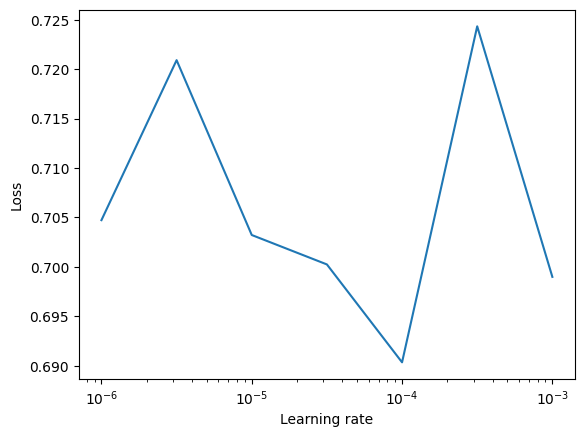

In [400]:
# plot the loss vs learning rate
plt.plot(lrs[:len(avg_losses)], avg_losses)
plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

The learning-rate curve is behaving as expected: at very small learning rates the loss barely changes, indicating that the updates are too small to matter; as the learning rate grows toward the mid-range, the loss steadily decreases, showing that the model is learning effectively; and once the learning rate becomes too large the loss suddenly rises, signaling that training is starting to diverge. The lowest point of the curve is near 1e-4, which suggests that this is a good learning rate to use in practice, or slightly below it if you prefer a more conservative choice.


Up to now, we’ve trained every layer of a model using a single learning rate for all parameters. That approach is reasonable when training from scratch, but transfer learning gives us the opportunity to do better. In our earlier experiments, we froze all pretrained layers and fine-tuned only the new classifier. A natural next step is to **unfreeze some of the layers just before the classifier and allow them to adapt slightly** to the new task. However, since those layers have already been trained extensively on ImageNet, **they usually require only small adjustments**, whereas our **newly added classifier needs much larger updates**. This mismatch can be solved by using **different learning rates for different parts of the model**. PyTorch makes easy to assign separate learning rates to different groups of parameters: 


In [401]:
# Define learning rate
learning_rate = 0.001

# Start with a pretrained RESNET model
resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1);

# Create the new classifier
new_classifier = nn.Sequential(
    nn.Linear(resnet_model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, 2)
)

# Assign the new classifier to the RESNET model
resnet_model.fc = new_classifier

# Define optimizer with different learning rates for different layers
optimizer_resnet = optim.Adam([
    { 'params': resnet_model.layer4.parameters(), 'lr': learning_rate/3},
    { 'params': resnet_model.layer3.parameters(), 'lr': learning_rate/9},
    { 'params': resnet_model.fc.parameters(), 'lr': learning_rate},
], lr=learning_rate)


This setup assigns a smaller learning rate to the deeper pretrained layers: layer4 receives one-third of the main learning rate, and layer3 receives one-ninth. In practice, this ratio often works well, though we can certainly experiment with other values. There is one important detail to remember, however. Earlier we froze all pretrained layers to prevent them from being updated. If we now want these layers to be fine-tuned (even at a reduced learning rate) we must first allow them to accumulate gradients again:

In [402]:
# Unfreeze layers
unfreeze_layers = [resnet_model.layer3, resnet_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

Now that these layers are allowed to accumulate gradients again, the different learning rates we assigned will actually take effect during fine-tuning. We can freeze or unfreeze any part of the model whenever we wish, giving us the **flexibility to refine specific layers independently**. 

### Data augmentation

Overfitting happens when a model learns the training set too precisely, essentially memorizing the answers, rather than discovering patterns that generalize to new, unseen examples. A classic defense against this is simply to gather more data, **forcing the model to compress the underlying structure instead of storing specific outcomes**. But what if we have only a limited dataset, as is often the case in transfer learning? One effective strategy is **data augmentation**: by transforming existing samples in ways that preserve their meaning, we can artificially **expand the diversity of the dataset** and make the model more robust. Consider the images of a cat:

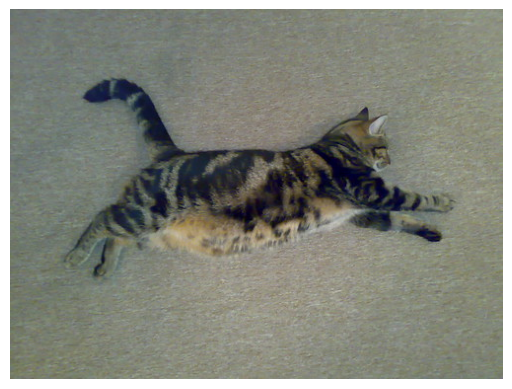

In [403]:
cat_sample = show_random_sample("cat");

We can for example apply a mirror flip to obtain a new image that still clearly depicts the same object:

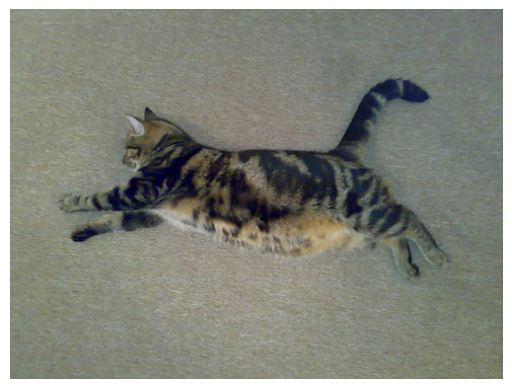

In [404]:
flip_transform = transforms.RandomHorizontalFlip(p=1.0)  
cat_sample_flipped = flip_transform(cat_sample)

plt.imshow(cat_sample_flipped)
plt.axis("off")
plt.show()

To us, these two images are clearly the same cat, their tensor representations, however, are different because the pixel values occupy different positions in the 3D RGB tensor. By training on both versions, **we encourage the model to recognize the essential shape of a cat whether it appears on the left or the right side of the frame**, rather than memorizing a single fixed layout. Torchvision provides a rich set of built-in transforms for data augmentation, along with simple mechanisms for creating our own custom transformations.

**ColorJetter** randomly changes the brightness, contrast, saturation, and hue of an image. This helps the model become invariant to different lighting conditions and color variations that might occur in real-world scenarios:

In [405]:
flip_transform = transforms.ColorJitter(brightness=0.5, 
                                        contrast=0.5, 
                                        saturation=0.5, 
                                        hue=0.5);

**RandomHorizontalFlip** and **RandomVerticalFlip** are used to flip the image horizontally or vertically with a given probability. This helps the model become invariant to the orientation of objects in the image:

In [406]:

flip_transform_h = transforms.RandomHorizontalFlip(p=0.5)
flip_transform_v = transforms.RandomVerticalFlip(p=0.5)

**RandomGrayscale** converts an image to grayscale with a specified probability. This encourages the model to focus on shapes and textures rather than relying solely on color information:

In [407]:
grayscale_transform = transforms.RandomGrayscale(p=0.3) 

**RandomCrop** and **RandomResizedCrop** both create random crops of the original image, but in slightly different ways. RandomCrop simply extracts a randomly positioned region of a specified size (either a single integer for a square crop or a tuple for separate height and width). RandomResizedCrop not only selects a random region but also resizes it to a target dimension, which introduces even more variability in scale and composition. These operations encourage the model to focus on the important parts of the object rather than memorizing its exact placement within the frame:

In [408]:
crop_transform = transforms.RandomCrop(size=30)
res_crop_transform = transforms.RandomResizedCrop(size=30, scale=(0.08, 1.0),
                                                      ratio=(0.75, 1.333), 
                                                      interpolation=2)

We need to use cropping with some care, because overly aggressive crops can remove the very features the model needs to learn. If the crop is too small or poorly positioned, we might end up training the network on irrelevant fragments (like a piece of a table instead of the cat sitting on it), which can confuse the classifier.

**RandomRotation** randomly rotates the image within a specified degree range. This helps the model become invariant to the orientation of objects in the image:

In [409]:
rotation_transform = transforms.RandomRotation(degrees=45)

**Pad** and **RandomAffine** add padding around the image or apply affine transformations (like rotation, translation, scaling, and shearing). These augmentations help the model generalize better by exposing it to a wider variety of spatial configurations:

In [410]:
pad_transform = transforms.Pad(padding=4, fill=0, padding_mode='constant')
affine_transform = transforms.RandomAffine(degrees=30, 
                                          translate=(0.1, 0.1), 
                                          scale=(0.8, 1.2), 
                                          shear=10)

Other transformations are available in torchvision, however in situations where the built-in transforms are not sufficient, we can define **a custom transform** that operates on either an image or a tensor. A custom transform is simply a Python class that implements two methods: "__call__", which performs the actual transformation when invoked in a transform pipeline, and "__repr__", which returns a readable description of the transform and any relevant parameters for debugging. The following example shows a transform that adds random Gaussian noise to an input tensor:


In [411]:
class NoiseTransform:

    def __init__(self, mean=0.0, stddev=0.1):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, tensor):
        # Generate noise with the same shape as the input tensor
        noise = torch.randn_like(tensor) * self.stddev + self.mean
        # Return a new tensor with noise added
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, stddev={self.stddev})"

With those transform functions defined, we can now plug them into a broader **data-augmentation pipeline**, combining thme using "transforms.Compose" to create a flexible and powerful preprocessing workflow. A good starting point is to use random flips, color jittering, rotations, and appropriately sized crops. These simple operations introduce enough variation to make the model more robust without distorting the underlying content. We can easily integrate these transforms into our existing data loading pipeline by modifying the dataset definition to include a composition of augmentations. We can create a new training dataset with data augmentation as follows:

In [412]:
train_transform_sequence = transforms.Compose([
    transforms.Resize((72, 72)),            # Slight upsample
    transforms.RandomResizedCrop(64,        # Random crop + resize
                                 scale=(0.8, 1.0),
                                 ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),  # Mirror flip
    transforms.RandomRotation(10),           # Small rotation
    transforms.ColorJitter(                  # Light color augmentation
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

train_data_augmented = torchvision.datasets.ImageFolder(root=train_data_path,
                                                        transform=train_transform_sequence)

train_data_loader_augmented = data.DataLoader(train_data_augmented, 
                                              batch_size=batch_size, 
                                              shuffle=True)

We change only the training dataset because data augmentation is intended to improve generalization during training. The validation and test datasets should remain unchanged to provide a consistent benchmark for evaluating model performance. With this augmented dataset in place, we can proceed to train our optimized RESnet model as before, now benefiting from the different learning rates and the increased diversity of training examples:

In [413]:
train(model=resnet_model, 
      optimizer=optimizer_resnet,
      loss_fn=torch.nn.CrossEntropyLoss(), 
      train_loader=train_data_loader_augmented,
      val_loader=val_data_loader,
      epochs=20,
      device="mps")

Epoch: 1, Training Loss: 0.40, Validation Loss: 0.27, accuracy = 0.94
Epoch: 2, Training Loss: 0.18, Validation Loss: 0.30, accuracy = 0.91
Epoch: 3, Training Loss: 0.06, Validation Loss: 0.37, accuracy = 0.92
Epoch: 4, Training Loss: 0.07, Validation Loss: 0.32, accuracy = 0.94
Epoch: 5, Training Loss: 0.03, Validation Loss: 0.25, accuracy = 0.95
Epoch: 6, Training Loss: 0.03, Validation Loss: 0.23, accuracy = 0.96
Epoch: 7, Training Loss: 0.04, Validation Loss: 0.26, accuracy = 0.94
Epoch: 8, Training Loss: 0.05, Validation Loss: 0.33, accuracy = 0.93
Epoch: 9, Training Loss: 0.05, Validation Loss: 0.18, accuracy = 0.96
Epoch: 10, Training Loss: 0.03, Validation Loss: 0.24, accuracy = 0.95
Epoch: 11, Training Loss: 0.02, Validation Loss: 0.22, accuracy = 0.94
Epoch: 12, Training Loss: 0.02, Validation Loss: 0.25, accuracy = 0.94
Epoch: 13, Training Loss: 0.02, Validation Loss: 0.18, accuracy = 0.94
Epoch: 14, Training Loss: 0.02, Validation Loss: 0.23, accuracy = 0.93
Epoch: 15, Trai

The model quickly adapts to the cat-versus-fish task, reaching high validation accuracy within just a few epochs, which confirms that the pretrained ResNet features combined with differential learning rates and augmentation are extremely effective. After the initial improvement, the validation loss begins to fluctuate while accuracy stays high, a sign that the model is now refining itself on a relatively small dataset and naturally showing small variations from epoch to epoch. Training loss continues to decrease toward zero, showing that the classifier layers are fitting the training set very well, while augmentation helps prevent dramatic overfitting. Overall, we’ve reached a level of performance that is close to the ceiling for this dataset, and the results demonstrate a very successful fine-tuning process. Finally, we can check the model on the test set to estimate its generalization error:


In [414]:
evaluate(resnet_model, test_data_loader, torch.nn.CrossEntropyLoss(), device="mps");

Test Loss: 0.3419, Accuracy: 0.9375


Test-set result confirms that **the model is genuinely generalizing well** and not just performing well on the validation set. The accuracy is very close to what you observed during training and validation, which means there is no significant drop when moving to completely unseen data. This is a strong indicator that the combination of pretrained ResNet features, selective fine-tuning with different learning rates, and a good augmentation pipeline has produced a model that captures the underlying distinctions between cats and fish rather than memorizing the training images. For a small, two-class dataset like this one, achieving around 94–95% test accuracy is excellent and likely close to the upper bound of what the dataset can support.

## Debugging

Debugging neural networks is just as important as designing and training them, because even the most elegant architecture can fail silently if something is wrong in the data flow, gradients, or internal representations. Modern deep learning models are complex systems with millions of parameters, deep computation graphs, and intricate interactions between layers, so understanding what happens inside them is essential for diagnosing errors and improving performance. Fortunately, the ecosystem surrounding PyTorch and other frameworks provides powerful tools that help us inspect models at every stage: from monitoring the training process, to visualizing activations, to analyzing computational bottlenecks.

### TensorBoard

TensorBoard is a web-based application that makes it easy to visualize different aspects of neural network training. We can **monitor accuracy, losses, activation values, and virtually any statistic** we choose to log, all in **real time**. Although originally developed for TensorFlow, its interface is general and simple enough that integrating it with PyTorch works almost the same way. It can be started from the command line and checked in a web browser or it can be also embedded directly inside a Jupyter notebook:

In [415]:
# Load the TensorBoard extension
#%load_ext tensorboard

The module for using TensorBoard with PyTorch is located in "torch.utils.tensorboard":

In [416]:
import time

# Create a run directory
from torch.utils.tensorboard import SummaryWriter
run_dir = f"runs/exp_{int(time.time())}"

# Initialize SummaryWriter
writer = SummaryWriter(run_dir)

# Log a simple scalar value
writer.add_scalar('example', 3)

We use the **SummaryWriter** class to communicate with TensorBoard, which by default logs output into the "./runs" directory. Scalars such as loss or accuracy are recorded with **add_scalar** using a descriptive tag. To show the TensorBoard, we simply point it to the directory where the log files are stored:

In [417]:
# Show a new cell with TensorBoard
#%tensorboard --logdir=runs

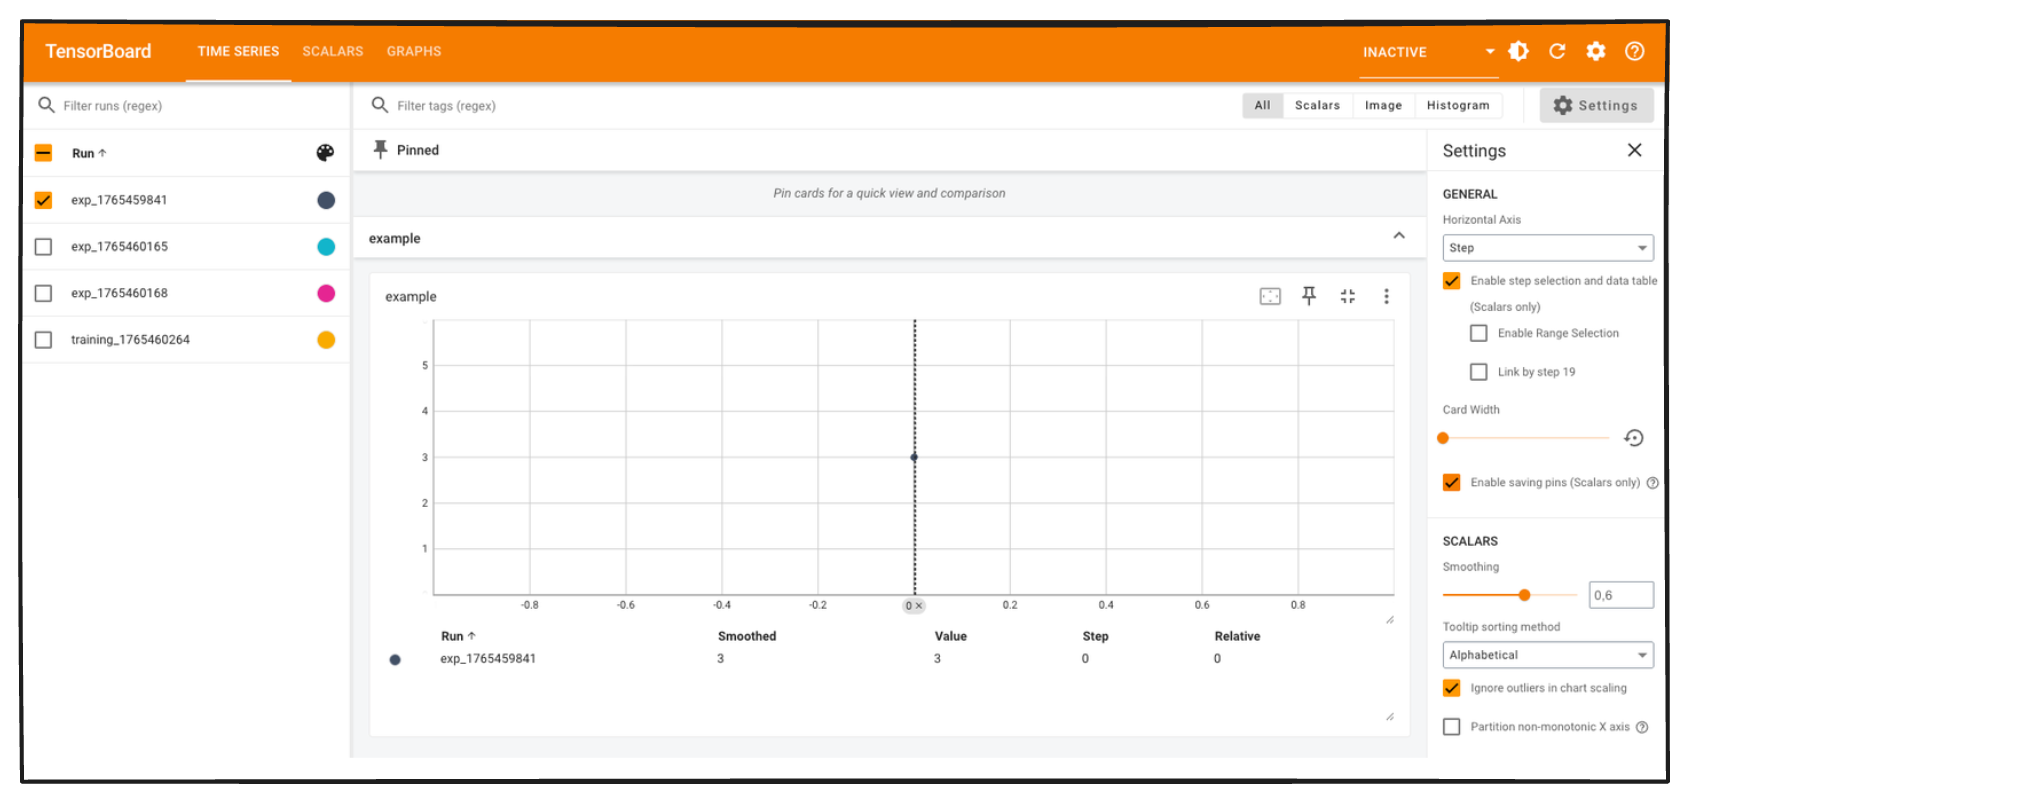

We can integrate the logging into a loop as follows:

In [418]:
# Create a new run directory
run_dir = f"runs/exp_{int(time.time())}"
writer = SummaryWriter(run_dir)

# Log a simple scalar value over iterations
value = 10
writer.add_scalar('test_loop', value, 0)
for i in range(1,10000):
    value += random.random() - 0.5
    writer.add_scalar('test_loop', value, i)

By logging the loop counter along with our values, TensorBoard plots the random values starting from 10. If we run the code again, TensorBoard will record a new run and the interface will let us choose whether to display all runs together or focus on specific ones. We can plot the TernsorBoard interface also in different cells of the notebook:

In [419]:
# Show a new cell with TensorBoard
#%tensorboard --logdir=runs

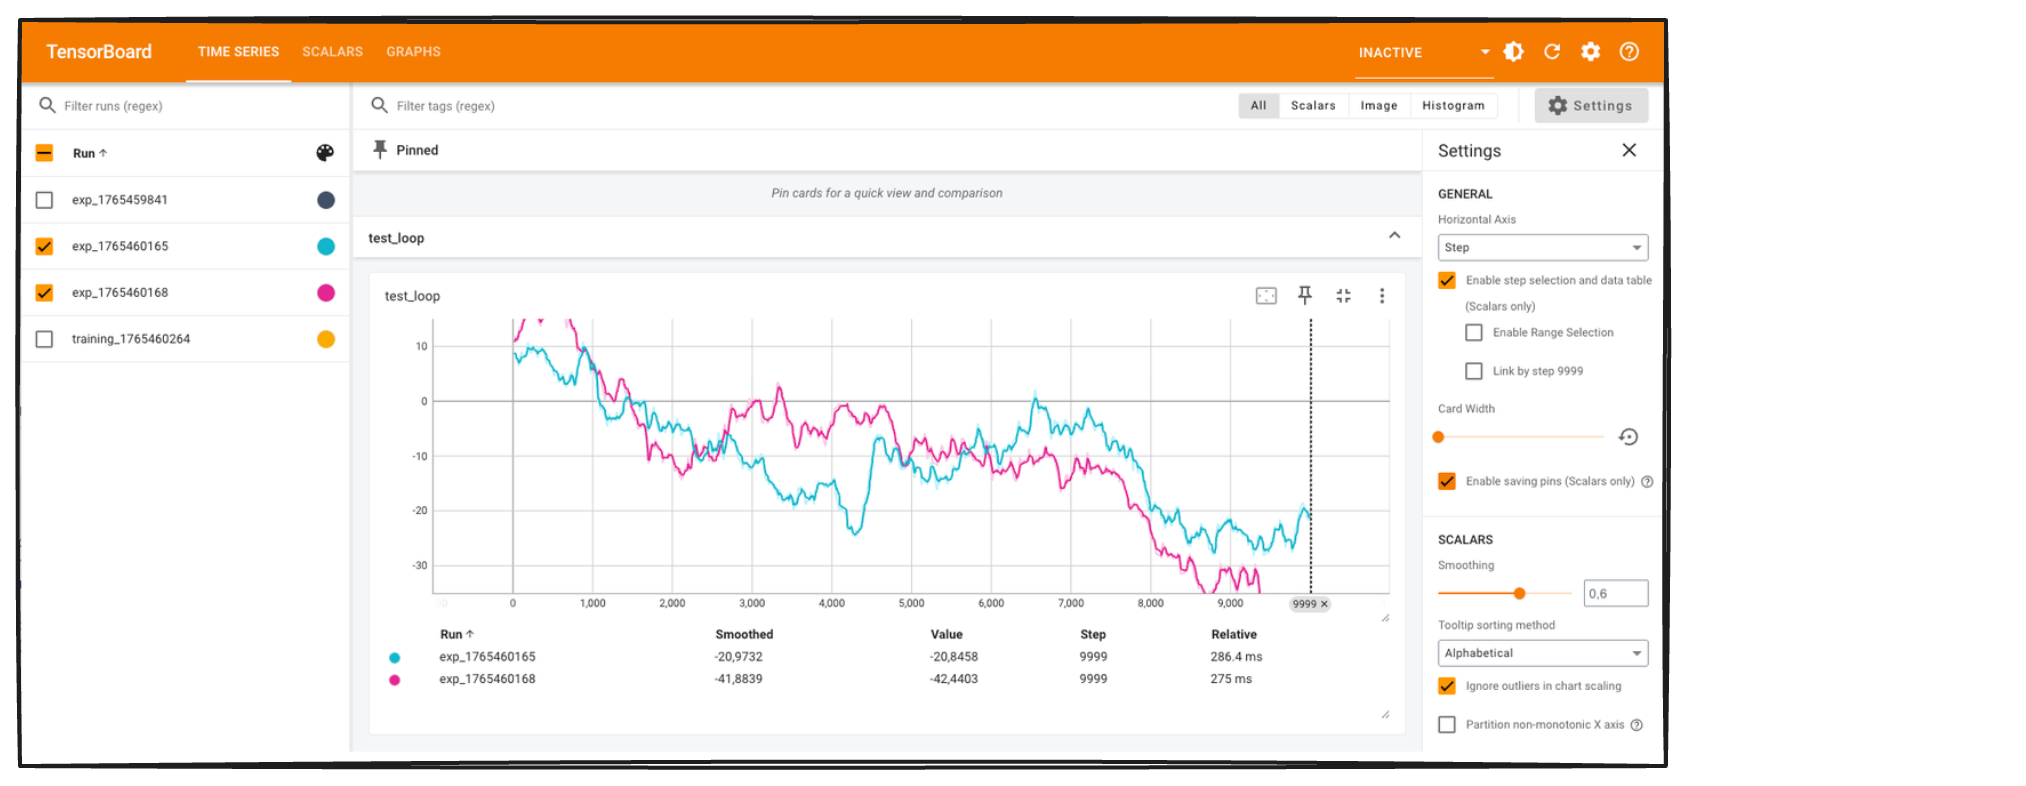

We can now replace the print statements in our training loop by logging the values directly to TensorBoard, gaining a clearer and more interactive view of how the model is learning:

In [420]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):

    # Initialize TensorBoard writer
    run_dir = f"runs/training_{int(time.time())}"
    writer = SummaryWriter(run_dir)

    # Move the model to device
    model = model.to(device)
    
    # Run the loop for the specified number of epochs
    for epoch in range(epochs):

        # Initialize running losses
        training_loss = 0.0
        valid_loss = 0.0
    
        # --- Training Phase ---

        # Set model to training mode
        model.train()
        
        # Training loop
        for batch in train_loader:

            # Zero the gradients
            optimizer.zero_grad()

            # Get the inputs and targets from the batch
            inputs, target = batch

            # Move data to the specified device
            inputs = inputs.to(device)
            target = target.to(device)

            # Forward pass
            output = model(inputs)

            # Compute loss
            loss = loss_fn(output, target)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate training loss
            training_loss += loss.item()
        
        # Average training loss
        training_loss /= len(train_loader)

        # --- Validation Phase ---


        # Set model to evaluation mode
        model.eval()

        # Count correct predictions
        num_correct = 0
        num_examples = 0
        
        # Validation loop

        with torch.no_grad(): # Disable gradient computation
            for batch in val_loader:

                # Get the inputs and targets from the batch
                inputs, targets = batch
                
                # Move data to the specified device
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                output = model(inputs)
                
                # Compute loss
                loss = loss_fn(output,targets)

                # Accumulate validation loss
                valid_loss += loss.item()

                # Check predictions
                pred = output.argmax(dim=1)   
                correct = (pred == targets)
                
                # Accumulate number of correct predictions
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]

            # Average validation loss    
            valid_loss /= len(val_loader)

        # --- Reporting ---

        # Write epoch statistics on TensorBoard
        writer.add_scalar('training loss', training_loss, epoch)
        writer.add_scalar('validation loss', valid_loss, epoch)
        writer.add_scalar('accuracy', num_correct / num_examples, epoch)

we can try this on our SimpleNet model on the cat-vs-fish dataset showing the TensorBoard interface:

In [421]:
# Create a new SimpleNet and optimizer
simplenet = SimpleNet()
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

# Show a new cell with TensorBoard
#%tensorboard --logdir=runs

# Train the model with TensorBoard logging
train(model=simplenet, 
      optimizer=optimizer,
      loss_fn=torch.nn.CrossEntropyLoss(), 
      train_loader=train_data_loader,
      val_loader=val_data_loader,
      epochs=20,
      device="mps")

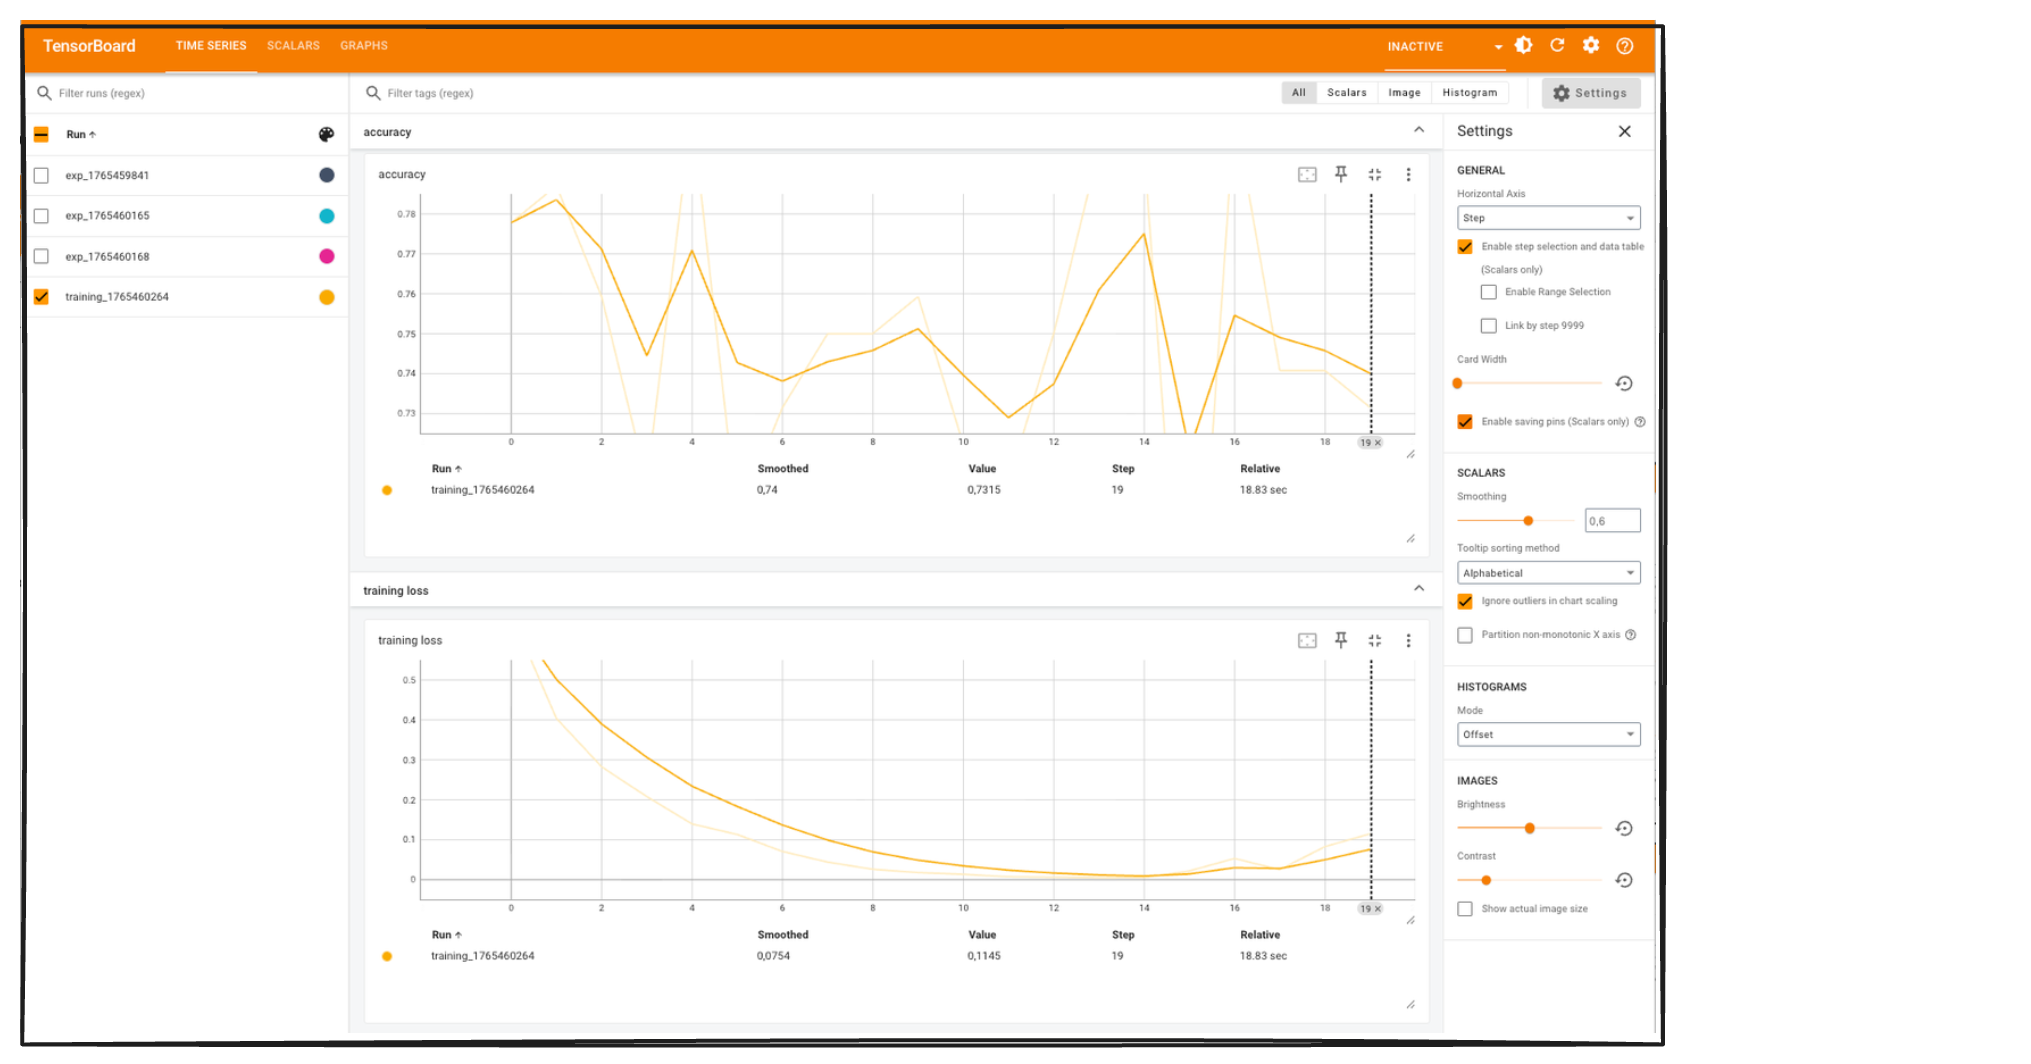

TensorBoard can even display the model architecture itself, giving us a visual representation of the network we’re training. Using **add_graph** we can show the **computational graph** of a PyTorch model. It works by tracing a forward pass: we give it a model and a sample input, and PyTorch records all the operations used to compute the output. TensorBoard can then display this trace as a graph, showing layers, shapes, and how data flows through the network:

In [422]:
# Add model graph to TensorBoard
dummy_input = torch.rand(1, 3, 64, 64).to("mps")
writer.add_graph(simplenet.to("mps"), dummy_input)

# Show a new cell with TensorBoard
#%tensorboard --logdir=runs

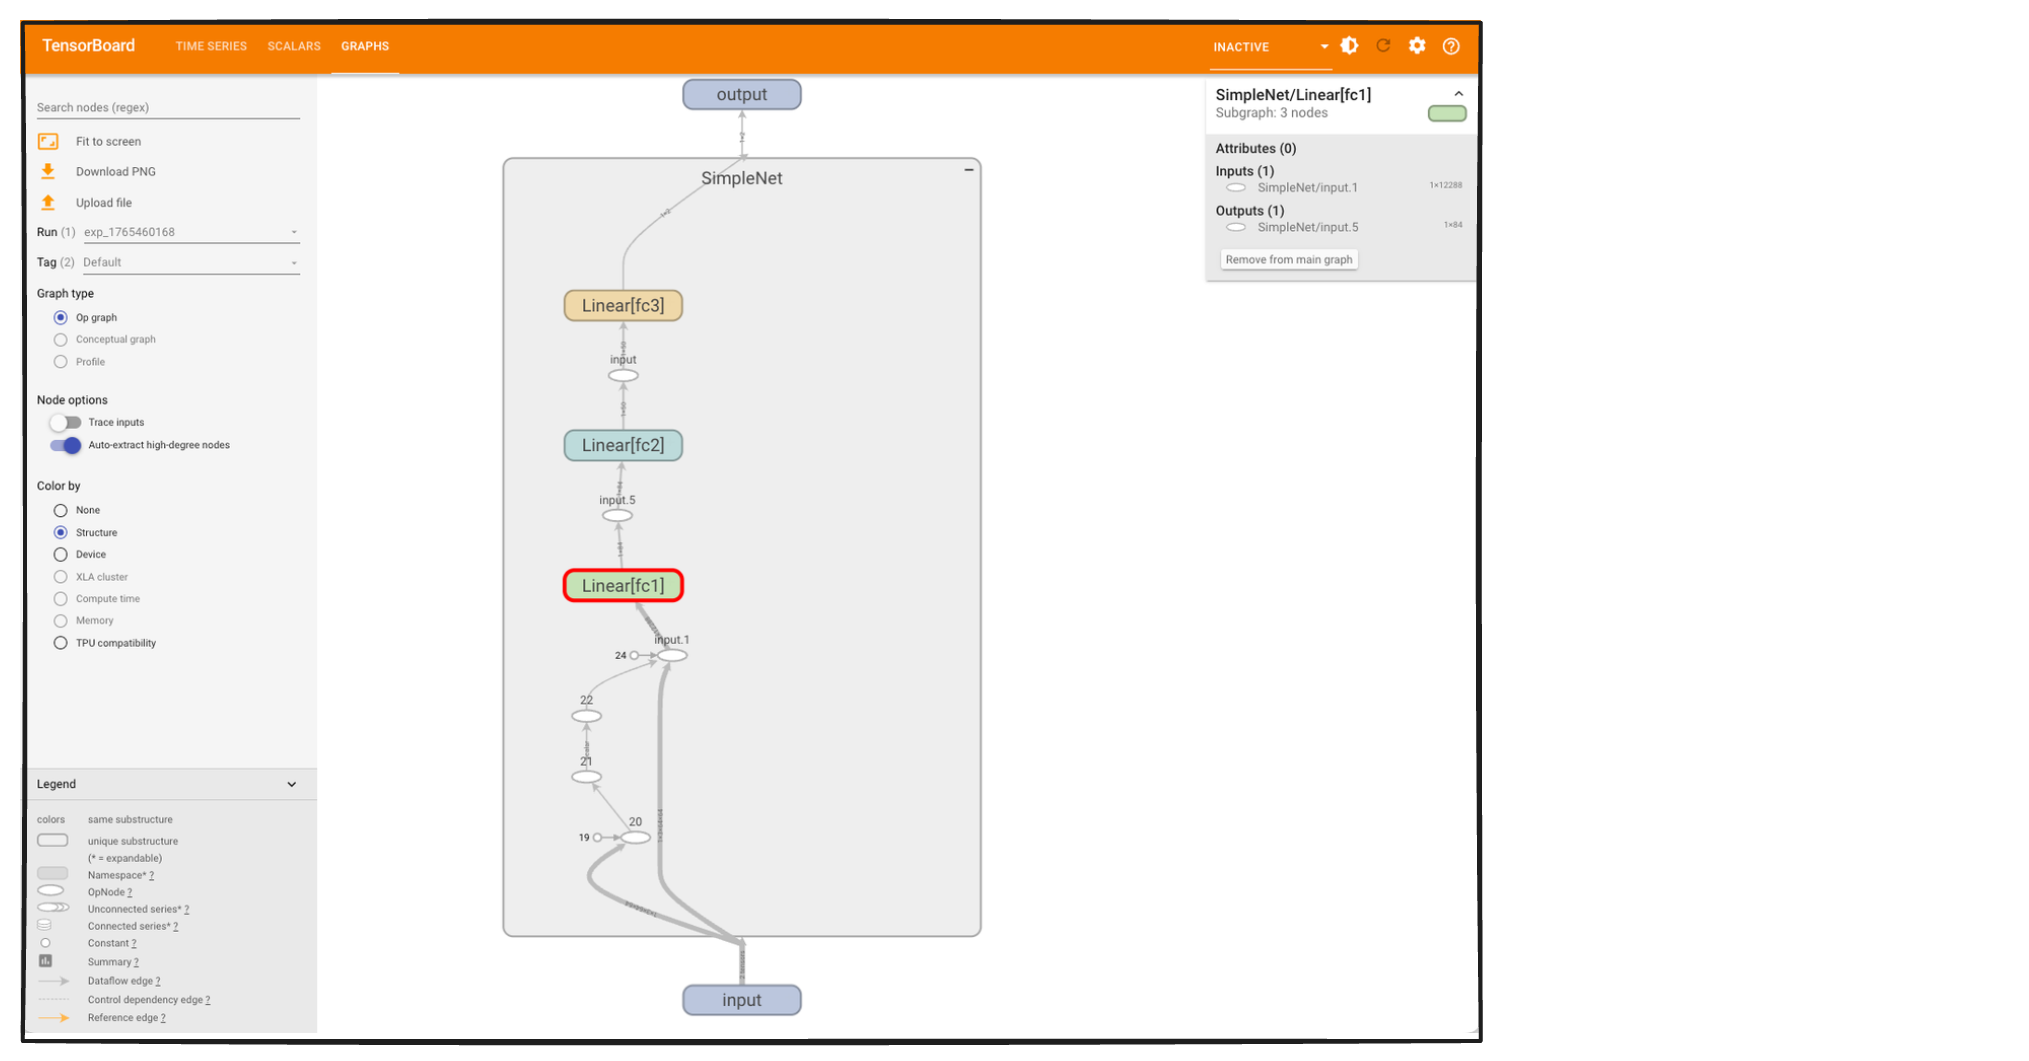

We can now send accuracy and loss metrics to TensorBoard, along with a visualization of the model’s structure. By collecting this information across multiple training runs, it becomes much easier to spot unusual patterns or performance drops and to understand why a particular run may have behaved differently.

### Hooks

Hooks are **functions** we can **attach to tensors or modules** so that they are **executed during the forward or backward pass**. Whenever PyTorch reaches a module with a registered hook, it **automatically calls that hook**, allowing us to inspect or even modify what is happening inside the network. A hook registered on a tensor is triggered when its gradient is computed, while a hook on a module is triggered when data flows through it.

Hooks are extremely powerful: they can overwrite activations, alter gradients, mask values, modify biases, or implement entirely custom behaviors. We will use them for a gentler purpose, simply to observe what happens inside a network as inputs move through its layers.

For example, given our SimpleNet model, we can attach a forward hook to inspect the activations produced by one of its layers:

In [423]:
# Define a hook function
def print_hook(module, input, output):
    print(f"Inside hook for: {module.__class__.__name__}")
    print(f"Input shape: {input[0].shape}")
    print(f"Output shape: {output.shape}")

# Register the hook to the first fully connected layer
hook_handle = simplenet.fc1.register_forward_hook(print_hook)

When a hook is attached to a module or tensor, PyTorch returns a **handle** that represents that specific hook. It’s important to keep this handle so that we can later call remove() when the hook is no longer needed. If we don’t store the reference, the hook will remain active for the lifetime of the program, consuming memory and potentially adding unnecessary computation during forward or backward passes. Now we can run a sample input through the model, and the hook will automatically print the shape of the input and output from the specified layer:

In [424]:
# Run a forward pass to see the hook in action
dummy_input = torch.rand(1, 3, 64, 64).to("mps")
simplenet(dummy_input);

Inside hook for: Linear
Input shape: torch.Size([1, 12288])
Output shape: torch.Size([1, 84])


It is possible also to remove the hook when it is no longer needed by calling the **remove()** method on the handle returned when registering the hook:

In [425]:
# Remove the hook when done
hook_handle.remove()

**Backward hooks** follow the same logic, except they are registered using **register_backward_hook()**. These hooks are called during backpropagation, allowing us to inspect or modify gradients as they flow backward through the network.

### Class Activation Mapping

**Class activation mapping (CAM)** is a technique used to visualize which regions of an input the network **focused** on when making a prediction. In image-classification models, CAMs are typically displayed as heatmaps overlaid on the original image, highlighting the areas that contributed most strongly to the final decision. 

As an example, to generate a CAM image for our ResNet model, we can grab information from the activations of the last convolutional layer, the point just before the network flattens the features and sends them into the fully connected classifier. This layer contains the **highest-level spatial information extracted by the CNN**, so visualizing it reveals what the model considers important in the image right before making a prediction. In our architecture, we can use "layer3",which is the second-to-last convolutional block, instead of the final one. This can often preferable for because it retains a higher spatial resolution, allowing the heatmap to localize important regions more precisely while still capturing meaningful, high-level visual features relevant to the model’s decision:

In [580]:
target_layer = resnet_model.layer3[-1]

To access this information, we define a **forward hook** to captures the feature maps produced by the last convolutional layer, essentially a set of spatial patterns the network has detected in the image (edges, textures, shapes), and a **backward hook** which provides the gradients flowing from the chosen class score back into those feature maps, telling us how strongly each map contributed to that specific prediction:

In [581]:
# Feature maps and gradients
feature_maps = None
gradients = None

# Define forward hook
def forward_hook(module, input, output):
    global feature_maps
    feature_maps = output

# Define backward hook
def backward_hook(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

We register the hooks to the final convolutional layer:

In [582]:
# Register the hooks
handle_fwd = target_layer.register_forward_hook(forward_hook)
handle_bwd = target_layer.register_full_backward_hook(backward_hook)

We load a sample image from the test set in order to run a forward and a backward pass through the network and capture the necessary data for CAM generation:

In [596]:
# Load a random cat image
cat_folder = "./data/cat-vs-fish/test/cat"
filename = random.choice(os.listdir(cat_folder))
img_path = os.path.join(cat_folder, filename)

# Open and preprocess the image
img = Image.open(img_path)
img_tensor = transform_sequence(img)
img_tensor = img_tensor.unsqueeze(0).to("mps")

Now we run the forward and backward passes through the network. During this process, the hooks will automatically capture the feature maps and gradients we need:

In [597]:
# Set model to evaluation mode
resnet_model.eval()

# Forward pass
output = resnet_model(img_tensor)
class_idx = output.argmax(dim=1).item()                 
score = output[0, class_idx]                  

# Backward pass
resnet_model.zero_grad()
score.backward()

During the backward pass, the gradients tell us how much changing each activation in the last convolutional layer would affect the score of the chosen class. If a small change in a feature map produces a large change in the class score, that feature map must be important for the decision. By averaging these gradients over all spatial locations, we compress this information into a single number per channel, which acts as an **importance weight** for that channel. In other words, each weight answers the question: **how useful was this feature detector for recognizing this class?**

$\displaystyle \alpha_k = \frac{1}{H W} \sum_{i,j}
\frac{\partial y^c}{\partial A^k_{ij}}$

where $\alpha_k$ is the weight for channel $k$, $y^c$ is the score for class $c$ and $A^k$ is the $k$-th feature map.

In [598]:
# Compute one weight per channel (global average pooling over spatial dims)
weights = gradients.mean(dim=(2, 3), keepdim=True)


Once we have one importance weight per channel, we go back to the feature maps produced during the forward pass. Each channel can be thought of as a detector for a specific visual pattern (such as edges, textures, or shapes). We combine them by taking a weighted sum, amplifying the feature maps that mattered most and suppressing the ones that mattered least. This produces a single 2D map that reflects **where the important visual evidence is located in the image**.

$\displaystyle \text{CAM}(i,j) = \sum_k \alpha_k  A^k_{ij}$

In [599]:
# Weighted combination
cam = (weights * feature_maps).sum(dim=1, keepdim=True)

Finally, applying a ReLU removes negative contributions, keeping only regions that **positively support** the prediction, since we are interested in what pushed the model toward this class, not what argued against it. Normalization rescales the values so they can be visualized as a heatmap.

$\displaystyle \text{CAM} = \frac{\max(0, \text{CAM}) - \min}{\max - \min}$

The result is a spatial map that answers the key interpretability question: which parts of the image most strongly influenced the model’s decision, and why.

In [600]:
# Apply ReLU
cam = F.relu(cam)

# Normalize
cam -= cam.min()
cam /= cam.max() + 1e-8

We can show the CAM heatmap overlaid on the original image to see which regions the model focused on when predicting "cat":

In [601]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Transale the original image to numpy
img_np = np.array(img)  

# Move CAM to CPU and convert to numpy and resize 
cam = cam.squeeze().detach().cpu().numpy() 
cam = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))

# Use the CAM ad a color map
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)

# Overlay (OpenCV uses BGR)
overlay = cv2.addWeighted(img_np[:, :, ::-1], 0.6, heatmap, 0.4, 0)

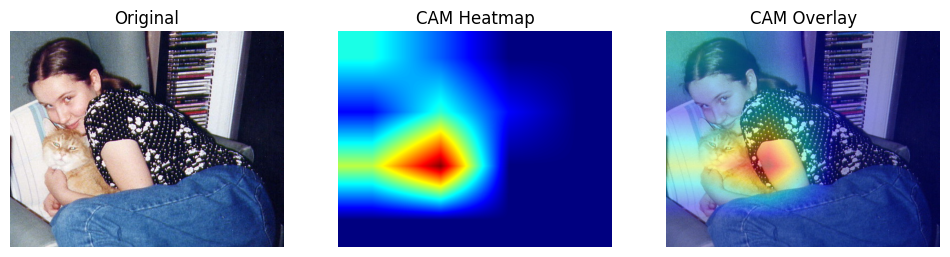

In [602]:
# Plot the original image, heatmap and overlay
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("CAM Heatmap")
plt.imshow(heatmap[:, :, ::-1])  # BGR -> RGB
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("CAM Overlay")
plt.imshow(overlay[:, :, ::-1])  # BGR -> RGB
plt.axis("off")

plt.show()

The result is reasonable and encouraging: the heatmap is smooth and spatially coherent, and when overlaid on the image it highlights the region containing the cat’s face and body, indicating that the ResNet is basing its decision on semantically meaningful parts of the image rather than on background artifacts, even though the activation is somewhat broad due to the coarse spatial resolution of the convolutional layer. We should always remember to remove the hooks after we are done using them to avoid unnecessary memory usage:

In [603]:
handle_fwd.remove()
handle_bwd.remove()